In [1]:
import pandas as pd
import os
import timesfm
import chronos
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import seaborn as sns

HORIZON_LEN = 168 # horizonte con el que predecimos
CONTEXT_LEN = 288 # contexto

TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.


c:\Users\Asier\miniconda3\envs\fforma\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded PyTorch TimesFM.


In [2]:
# For PyTorch
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          context_len=CONTEXT_LEN,  # Example input length
          horizon_len=HORIZON_LEN,  # Example output length
          backend='gpu',
          per_core_batch_size=32,
          input_patch_len=32,
          output_patch_len=128,
          num_layers=50,
          model_dims=1280,
          
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )


Fetching 3 files: 100%|██████████| 3/3 [00:00<?, ?it/s]


In [2]:
pipeline = chronos.BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    device_map="cuda",  # use "cpu" for CPU inference
    torch_dtype=torch.bfloat16,
)

TimesFM fixed


In [32]:
folder = "../../goi4_pst/imp_csv/"
timesfm_folder = "../../Resultados/TimesFM/"

all_mapes = []
all_rmses = []
all_ids = []
# Iterar sobre cada archivo en la carpeta
for filename in os.listdir(folder):
    preds = pd.DataFrame(columns=['id', 'timestamp', 'pred', 'real', 'mape', 'rmse'])

    if filename.endswith('.csv'):
        file_path = os.path.join(folder, filename)

        try:
            # Leer el archivo CSV
            df = pd.read_csv(file_path, index_col=None)

            # Verificar que las columnas necesarias estén presentes
            if all(col in df.columns for col in ['timestamp', 'kWh', 'imputed']):
                file_id = os.path.splitext(filename)[0]

                # Convertir la columna 'timestamp' a datetimea
                df['timestamp'] = pd.to_datetime(df['timestamp'])

                # Seleccionar solo las columnas necesarias
                df = df[['timestamp', 'kWh', 'imputed']]
                df = df[df['kWh'] != 0]


                #* ejecutar aqui la prediccion e ir añadiendo resultados

                dataframe_original = df.copy() 
                dataframe_remove = dataframe_original.iloc[:-HORIZON_LEN].copy() #quitando datos a predecir
                dataframe_rdata = dataframe_original.iloc[-HORIZON_LEN:].copy() #datos a predecir

                input_df = dataframe_remove  # Cambia el índice según la serie que deseas usar

                # Reset the index to make 'timestamp' a column again
                input_df.reset_index(inplace=True)

                # Renombrar columnas para cumplir con los requisitos de timesfm
                input_df.rename(columns={"timestamp": "ds", "kWh": "kWh"}, inplace=True)

                # Agregar una columna 'unique_id'
                input_df['unique_id'] = 'series_1'  # Asigna un ID único para esta serie

                # Pronosticar
                forecast_df = tfm.forecast_on_df(
                    inputs=input_df,
                    freq="h",  # hourly
                    value_name="kWh",
                    num_jobs=-1,
                )

                prediccion = forecast_df.copy()
                prediccion = prediccion.iloc[:,:3]

                y_true = dataframe_rdata['kWh'].values  # Esto ya es un array de NumPy, no necesitas .values
                y_pred = prediccion['timesfm'].values   # Lo mismo aquí
                
                # Asegúrate de que ambos DataFrames tengan el mismo índice
                dataframe_rdata = dataframe_rdata.reset_index(drop=True)
                prediccion = prediccion.reset_index(drop=True)


                # Calcular MAPE usando solo los valores donde y_true no es cero
                mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
                rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

                # Crear un nuevo DataFrame con la nueva fila
                all_mapes.append(mape)
                all_rmses.append(rmse)
                all_ids.append(file_id)

                pred_row = pd.DataFrame({
                    'id': [file_id] * HORIZON_LEN,  # Replicar 'filename' para cada fila
                    'timestamp': prediccion['ds'],
                    'pred': y_pred,
                    'real': y_true,
                    'mape': [mape] * HORIZON_LEN,
                    'rmse': [rmse] * HORIZON_LEN

                })
              
                preds_file = os.path.join(timesfm_folder, 'preds', 'timesfm_fixed',  filename)
                

                pred_row.to_csv(preds_file, index=False)
                print(f"Prediccion de {filename} guardado correctamente")

         
            else:
                print(f"El archivo {filename} no contiene las columnas requeridas.")
        except Exception as e:
            print(f"Error al procesar el archivo {filename}: {e}")

errors = pd.DataFrame({
    'id': all_ids,
    'mape': all_mapes,
    'rmse': all_rmses
})
errors_file = os.path.join(timesfm_folder, 'errores', "timesfm_fixed_errors.csv")
errors.to_csv(errors_file, index=False)


Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Prediccion de 0001b3b2f18c01c62ed9b2a87de7b4e33e7836f786f7904471d8866978405c1b.csv guardado correctamente
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Prediccion de 0004150214d14a2b2e6f7075531e661cf465b27ec4d0d53573866df2c97b8313.csv guardado correctamente
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Prediccion de 000721f0fc6ccf02ae24b67393979513171f2abc119af07a7abed20ca303b665.csv guardado correctamente
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Prediccion de 0009b156f2a1213a137c150f4787150384938eac15cc2044a10c797d98667a91.csv guardado correctamente
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Prediccion de 000bf84faacf921b55bd4ec4aecda599754e9017e150091d330a

KeyboardInterrupt: 

In [33]:
errors = pd.DataFrame({
    'id': all_ids,
    'mape': all_mapes,
    'rmse': all_rmses
})
errors_file = os.path.join(timesfm_folder, 'errores', "timesfm_fixed_errors.csv")
errors.to_csv(errors_file, index=False)

TimesFM random

In [6]:
folder = "../../goi4_pst/imp_csv/"
timesfm_folder = "../../Resultados/TimesFM/"

all_mapes = []
all_rmses = []
all_ids = []
# Iterar sobre cada archivo en la carpeta
for filename in os.listdir(folder):
    preds = pd.DataFrame(columns=['id', 'timestamp', 'pred', 'real', 'mape', 'rmse'])

    if filename.endswith('.csv') and filename in os.listdir(os.path.join(timesfm_folder, "preds", "timesfm_fixed")):
        file_path = os.path.join(folder, filename)

        try:
            # Leer el archivo CSV
            dataframe_original = pd.read_csv(file_path, index_col=None)

            # Verificar que las columnas necesarias estén presentes
            if all(col in dataframe_original.columns for col in ['timestamp', 'kWh', 'imputed']):
                file_id = os.path.splitext(filename)[0]

                # Convertir la columna 'timestamp' a datetimea
                dataframe_original['timestamp'] = pd.to_datetime(dataframe_original['timestamp'])

                # Seleccionar solo las columnas necesarias
                dataframe_original = dataframe_original[['timestamp', 'kWh', 'imputed']]
                dataframe_original = dataframe_original[dataframe_original['kWh'] != 0]


                #* ejecutar aqui la prediccion e ir añadiendo resultados
                if len(dataframe_original) < CONTEXT_LEN+HORIZON_LEN: #168 a predecir y 288 datos necesarios
                    print("La serie temporal es demasiado corta para pronosticar.")
                    continue
                else:
                    num = random.randint(CONTEXT_LEN,len(dataframe_original)-1)

                dataframe_original = dataframe_original.iloc[:num].copy()
                dataframe_remove = dataframe_original.iloc[:-HORIZON_LEN].copy() #quitando datos a predecir
                dataframe_rdata = dataframe_original.iloc[-HORIZON_LEN:].copy() #datos a predecir

                input_df = dataframe_remove  # Cambia el índice según la serie que deseas usar

                # Reset the index to make 'timestamp' a column again
                input_df.reset_index(inplace=True)

                # Renombrar columnas para cumplir con los requisitos de timesfm
                input_df.rename(columns={"timestamp": "ds", "kWh": "kWh"}, inplace=True)

                # Agregar una columna 'unique_id'
                input_df['unique_id'] = 'series_1'  # Asigna un ID único para esta serie

                # Pronosticar
                forecast_df = tfm.forecast_on_df(
                    inputs=input_df,
                    freq="h",  # hourly
                    value_name="kWh",
                    num_jobs=-1,
                )

                prediccion = forecast_df.copy()
                prediccion = prediccion.iloc[:,:3]

                y_true = dataframe_rdata['kWh'].values  # Esto ya es un array de NumPy, no necesitas .values
                y_pred = prediccion['timesfm'].values   # Lo mismo aquí
                
                # Asegúrate de que ambos DataFrames tengan el mismo índice
                dataframe_rdata = dataframe_rdata.reset_index(drop=True)
                prediccion = prediccion.reset_index(drop=True)


                # Calcular MAPE usando solo los valores donde y_true no es cero
                mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
                rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

                # Crear un nuevo DataFrame con la nueva fila
                all_mapes.append(mape)
                all_rmses.append(rmse)
                all_ids.append(file_id)

                pred_row = pd.DataFrame({
                    'id': [file_id] * HORIZON_LEN,  # Replicar 'filename' para cada fila
                    'timestamp': prediccion['ds'],
                    'pred': y_pred,
                    'real': y_true,
                    'mape': [mape] * HORIZON_LEN,
                    'rmse': [rmse] * HORIZON_LEN

                })
              
                preds_file = os.path.join(timesfm_folder, 'preds', 'timesfm_random', filename)
                

                pred_row.to_csv(preds_file, index=False)
                print(f"Prediccion de {filename} guardado correctamente")

         
            else:
                print(f"El archivo {filename} no contiene las columnas requeridas.")
        except Exception as e:
            print(f"Error al procesar el archivo {filename}: {e}")

errors = pd.DataFrame({
    'id': all_ids,
    'mape': all_mapes,
    'rmse': all_rmses
})
errors_file = os.path.join(timesfm_folder, 'errores', "timesfm_random_errors.csv")
errors.to_csv(errors_file, index=False)


Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Prediccion de 0001b3b2f18c01c62ed9b2a87de7b4e33e7836f786f7904471d8866978405c1b.csv guardado correctamente
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Prediccion de 0004150214d14a2b2e6f7075531e661cf465b27ec4d0d53573866df2c97b8313.csv guardado correctamente
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Prediccion de 000721f0fc6ccf02ae24b67393979513171f2abc119af07a7abed20ca303b665.csv guardado correctamente
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Prediccion de 0009b156f2a1213a137c150f4787150384938eac15cc2044a10c797d98667a91.csv guardado correctamente
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Prediccion de 000bf84faacf921b55bd4ec4aecda599754e9017e150091d330a

Chronos fixed

In [9]:
folder = "../../goi4_pst/imp_csv/"
timesfm_folder = "../../Resultados/TimesFM/"

all_mapes = []
all_rmses = []
all_ids = []
# Iterar sobre cada archivo en la carpeta
for filename in os.listdir(folder):
    preds = pd.DataFrame(columns=['id', 'timestamp', 'pred', 'real', 'mape', 'rmse'])

    if filename.endswith('.csv') and filename in os.listdir(os.path.join(timesfm_folder, "preds", "timesfm_fixed")):
        file_path = os.path.join(folder, filename)

        try:
            # Leer el archivo CSV
            df = pd.read_csv(file_path, index_col=None)

            # Verificar que las columnas necesarias estén presentes
            if all(col in df.columns for col in ['timestamp', 'kWh', 'imputed']):
                file_id = os.path.splitext(filename)[0]

                # Convertir la columna 'timestamp' a datetimea
                df['timestamp'] = pd.to_datetime(df['timestamp'])

                # Seleccionar solo las columnas necesarias
                df = df[['timestamp', 'kWh', 'imputed']]
                df = df[df['kWh'] != 0]


                #* ejecutar aqui la prediccion e ir añadiendo resultados

                # Crear copias y particionar los datos
                dataframe_original = df.copy()
                dataframe_remove = dataframe_original.iloc[:-HORIZON_LEN].copy()
                dataframe_rdata = dataframe_original.iloc[-HORIZON_LEN:].copy()

                # Establecer 'timestamp' como índice y renombrar para cumplir con timesfm
                dataframe_remove = dataframe_remove.rename(columns={"timestamp": "ds", "kWh": "kWh"})

                # Paso 1: Obtener el último timestamp del dataframe_remove
                last_timestamp = pd.to_datetime(dataframe_remove['ds'].iloc[-1])

                # Paso 2: Generar un rango de fechas para el pronóstico
                forecast_timestamps = pd.date_range(
                    start=last_timestamp + pd.Timedelta(hours=1),  # El siguiente periodo
                    periods=HORIZON_LEN,  # Longitud del pronóstico
                    freq="h"  # Frecuencia horaria
                )

                # Paso 3: Pronosticar con Chronos
                quantiles, mean = pipeline.predict_quantiles(
                    context=torch.tensor(dataframe_remove['kWh'].values),
                    prediction_length=HORIZON_LEN,
                    quantile_levels=[0.5],
                )

                # Paso 4: Convertir el pronóstico en un DataFrame con timestamps
                forecast_chronos = pd.DataFrame({
                    "timestamp": forecast_timestamps,
                    "forecast": mean.flatten().numpy()
                })

                prediccion = forecast_chronos[['timestamp','forecast']].copy()

                y_true = dataframe_rdata['kWh'].values  
                y_pred = prediccion['forecast'].values   # Lo mismo aquí
                
                # Asegúrate de que ambos DataFrames tengan el mismo índice
                dataframe_rdata = dataframe_rdata.reset_index(drop=True)
                prediccion = prediccion.reset_index(drop=True)

                # Calcular MAPE usando solo los valores donde y_true no es cero
                mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
                rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

                # Crear un nuevo DataFrame con la nueva fila
                all_mapes.append(mape)
                all_rmses.append(rmse)
                all_ids.append(file_id)

                pred_row = pd.DataFrame({
                    'id': [file_id] * HORIZON_LEN,  # Replicar 'filename' para cada fila
                    'timestamp': prediccion['timestamp'],
                    'pred': y_pred,
                    'real': y_true,
                    'mape': [mape] * HORIZON_LEN,
                    'rmse': [rmse] * HORIZON_LEN

                })
              
                preds_file = os.path.join(timesfm_folder, 'preds', 'chronos_fixed', filename)
                

                pred_row.to_csv(preds_file, index=False)
                print(f"Prediccion de {filename} guardado correctamente")

         
            else:
                print(f"El archivo {filename} no contiene las columnas requeridas.")
        except Exception as e:
            print(f"Error al procesar el archivo {filename}: {e}")

errors = pd.DataFrame({
    'id': all_ids,
    'mape': all_mapes,
    'rmse': all_rmses
})
errors_file = os.path.join(timesfm_folder, 'errores', "chronos_fixed_errors.csv")
errors.to_csv(errors_file, index=False)

We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0001b3b2f18c01c62ed9b2a87de7b4e33e7836f786f7904471d8866978405c1b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0004150214d14a2b2e6f7075531e661cf465b27ec4d0d53573866df2c97b8313.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 000721f0fc6ccf02ae24b67393979513171f2abc119af07a7abed20ca303b665.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0009b156f2a1213a137c150f4787150384938eac15cc2044a10c797d98667a91.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 000bf84faacf921b55bd4ec4aecda599754e9017e150091d330afc038f0fab11.csv guardado correctamente


KeyboardInterrupt: 

Chronos random

In [3]:
folder = "../../goi4_pst/imp_csv/"
timesfm_folder = "../../Resultados/TimesFM/"

all_mapes = []
all_rmses = []
all_ids = []
# Iterar sobre cada archivo en la carpeta
for filename in os.listdir(folder):
    preds = pd.DataFrame(columns=['id', 'timestamp', 'pred', 'real', 'mape', 'rmse'])

    if filename.endswith('.csv') and filename in os.listdir(os.path.join(timesfm_folder, "preds", "timesfm_fixed")):
        file_path = os.path.join(folder, filename)

        try:
            # Leer el archivo CSV
            df = pd.read_csv(file_path, index_col=None)

            # Verificar que las columnas necesarias estén presentes
            if all(col in df.columns for col in ['timestamp', 'kWh', 'imputed']):
                file_id = os.path.splitext(filename)[0]

                # Convertir la columna 'timestamp' a datetimea
                df['timestamp'] = pd.to_datetime(df['timestamp'])

                # Seleccionar solo las columnas necesarias
                df = df[['timestamp', 'kWh', 'imputed']]
                df = df[df['kWh'] != 0]


                #* ejecutar aqui la prediccion e ir añadiendo resultados

                if len(df) < CONTEXT_LEN + HORIZON_LEN:
                    print(f"La serie {file_id} es demasiado corta para pronosticar.")
                    continue

                num = random.randint(CONTEXT_LEN, len(df) - HORIZON_LEN)
                dataframe_original = df.copy().iloc[:num]  # Definir correctamente
                dataframe_remove = dataframe_original.iloc[:-HORIZON_LEN].copy()
                dataframe_rdata = dataframe_original.iloc[-HORIZON_LEN:].copy()

                # Establecer 'timestamp' como índice y renombrar para cumplir con timesfm
                dataframe_remove = dataframe_remove.rename(columns={"timestamp": "ds", "kWh": "kWh"})

                # Generar un rango de fechas para el pronóstico
                last_timestamp = pd.to_datetime(dataframe_remove['ds'].iloc[-1])
                forecast_timestamps = pd.date_range(
                    start=last_timestamp + pd.Timedelta(hours=1),
                    periods=HORIZON_LEN,
                    freq="h"
                )

                # Pronosticar con Chronos
                context_data = dataframe_remove['kWh'].values[-CONTEXT_LEN:]
                context = torch.tensor(context_data)

                quantiles, mean = pipeline.predict_quantiles(
                    context=context,
                    prediction_length=HORIZON_LEN,
                    quantile_levels=[0.5],
                )

                # Convertir el pronóstico en un DataFrame con timestamps
                forecast_chronos = pd.DataFrame({
                    "timestamp": forecast_timestamps,
                    "forecast": mean.flatten().numpy()
                })

                if "forecast" not in forecast_chronos.columns:
                    print(f"Error: La predicción de {file_id} no generó datos válidos.")
                    continue

                prediccion = forecast_chronos[['timestamp','forecast']].copy()

                y_true = dataframe_rdata['kWh'].values  
                y_pred = prediccion['forecast'].values   # Lo mismo aquí
                
                # Asegúrate de que ambos DataFrames tengan el mismo índice
                dataframe_rdata = dataframe_rdata.reset_index(drop=True)
                prediccion = prediccion.reset_index(drop=True)

                # Calcular MAPE usando solo los valores donde y_true no es cero
                mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
                rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

                # Crear un nuevo DataFrame con la nueva fila
                all_mapes.append(mape)
                all_rmses.append(rmse)
                all_ids.append(file_id)

                pred_row = pd.DataFrame({
                    'id': [file_id] * HORIZON_LEN,  # Replicar 'filename' para cada fila
                    'timestamp': prediccion['timestamp'],
                    'pred': y_pred,
                    'real': y_true,
                    'mape': [mape] * HORIZON_LEN,
                    'rmse': [rmse] * HORIZON_LEN

                })
              
                preds_file = os.path.join(timesfm_folder, 'preds', 'chronos_random', filename)
                

                pred_row.to_csv(preds_file, index=False)
                print(f"Prediccion de {filename} guardado correctamente")

         
            else:
                print(f"El archivo {filename} no contiene las columnas requeridas.")
        except Exception as e:
            print(f"Error al procesar el archivo {filename}: {e}")

errors = pd.DataFrame({
    'id': all_ids,
    'mape': all_mapes,
    'rmse': all_rmses
})
errors_file = os.path.join(timesfm_folder, 'errores', "chronos_random_errors.csv")
errors.to_csv(errors_file, index=False)

We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0001b3b2f18c01c62ed9b2a87de7b4e33e7836f786f7904471d8866978405c1b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0004150214d14a2b2e6f7075531e661cf465b27ec4d0d53573866df2c97b8313.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 000721f0fc6ccf02ae24b67393979513171f2abc119af07a7abed20ca303b665.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0009b156f2a1213a137c150f4787150384938eac15cc2044a10c797d98667a91.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 000bf84faacf921b55bd4ec4aecda599754e9017e150091d330afc038f0fab11.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 000da4922a91b9895f9f871225d8e3b9a1bbd51c3a29100b14864b75f0188534.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 001be27fc1f3e2daa58919a9de02e9e1b4a2ffb0fc8ebe2acb747f52a30acf32.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 001f110aa2520c6822370ae277427326684ce4e6504043c627fe77c860fbdcd9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0023b502d95ae54c7c0e5f7a3cef3ad620651efe04e4253bfd3ada4e62161dfe.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0024e07345b50dd266c6390d5c496a1bad30a85d8cff3ab80b78ce16102c008a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00264d835371489e86312529d5e5aa786f8c92faa96da2329dd4ccf526855527.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 002da62dc54b7a789473182feddfad7c185a94608196e9169bf61a17a90e6915.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 002dee79e61047af5f33e9fc617562a4117e25ca2192ed01c6608f37760c9504.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 002ed9a37fb8cf35ccd34afffb48add82354efd8a61c615b3c0f08b33c3404d8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00360f8639d63be18f35bf7181f155f69bf176003b5ee3916ea427c508085a35.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00489151865c9806ea977413603cc72b8bc27ff57350e878fcbedcb4d69317b1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 004a149b06c038586f30361ac6f16adb2ee32aee5f80784a4bda6a257814a9a4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0050b980111bad9422575db977d18199b5426cfa491073e4be3efa1acb1aa136.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0051177c9c0ec5ba203990395f5e785e9e913321576aed98d30b9ccab17d5823.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0052816ff7fcdf2a35953c34f9f2ea4c127623533e3274ce46bf0a7c3956f1ac.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0054900c9a8b6e82d6c102fe69ce4ec95fd189f23336f2c72fb46e2e3bef283a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 005932ecd8e0888863372c2ca998801ea6a7f2fef1e9dde0035d5c68c92bc145.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 005b44a54261c2606e2c5c9a1e8ff47c933f023d59cb171c0df08cea878403bf.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 005e34f194141e43c7d90738e0d76a38f074f5afb8daf2540023f38851a85ac2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0062c8d5ca7dfed574aab968f665978a9cb770a0d8f325cdfc741d3cd6f60cb1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0066a46980ca4c76f2f6306e206551be2da36363237dffffd03b01934a1514bf.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00688d15088ce2e0fcb251e2cad627a0b1bd2f2d5c462c9fb28cd22449cbc8db.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 006c6b188f8063853123d3a89e5357e1349bfdaad288e8669e7007310a391914.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 006ea886c093fa2bd562ab4d05e9577bdfd49b1f2c517481aeb5e4497d995f0a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00740539bc141a16321919f2a16b6c364a38047b84bb982cf9165dc604fab931.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 007aaadc125bb4e442192aa3daafcf7c602eafed4cb91e3b0adaa541983e17ea.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 008991fb296b8cd6a34324ef4e67b8d5244048a602418cc9c7e7982660d34a11.csv guardado correctamente
La serie 008a62eeaa03dd8db7364cda08f2c21e0475d8b18b0499d2734ab8aab34da300 es demasiado corta para pronosticar.


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00905e8f95cd93ad4224ad1e0df9951034f0861a6cf532917dff60d0adb70120.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 009068be20fff45059b714e85094b67f91dcb1dc7f3defc74d27ab615ca85427.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0092f0cfe994ff786f9dd416d896c5f9fe01ab60b214f86cba2a6c295e1de3b1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0093f0f5f552471964e924c74d2d163fc47842fd5ac7d6519bc1ef705e478017.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 009429775691556a0529b6c9cb32449af8f8327d32b9bbb9e6b40cddd396be50.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0095718db50e623fbb7b220243bb62845c8e78e8ab1fc6886f3019ce121fc435.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00983b85e8be33dbe113890de6f1e1566d7fa82a3562a7cc986e4075d3287a39.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00991127eac61693a824e0eb0ccda185348907f621a1079d6e55e79292234ffe.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00999d23b624f00a5e44f9e7b6e91a7b85970dcecfe324f0edc695060fee449e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 009d5a80c53ac2b2da3ba7419dacf6e22de58c96ce67f8ad3646f16340f1bff1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00a1614dc0e671ec0ee50aa63f15a9018417717d3e000e2757966dadc0ae1f9c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00a3e40e4b2e270f037660791016399b73ca116df989ea7fa640b9097247d2bb.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00ace226e25ab036833cf6d4546aff0e9e7f47514af0c7804a5b04cb27e0f940.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00ade7cf30a1e62b1632706aac0ccc56fa9237f0469c12d2a8cf1d5cb0fd5e53.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00adfecd32b7b6770c42f3c166696578518a90490f8958656be3920ad4c095ea.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00af05a1bb1f2f85d0574659cd91daaebcbadf2fe128f6363a31df311ace9433.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00afe36f1b78e683be4ca713b50860920a18a1f0df2a6bf3a126d6f412abdce8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00b12d888bf5b4bf1d830c4a192fdb0102b088965edbd74713c55f65fa41598d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00b1b22bceeb8b1bc4f837ac1a0a3df3078728d284e39d596c59b8150b9d5c16.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00b1bbe1d82e9e1b5d4a1ae1dacd3ffa0e9191de495167f9bcf08e7003f77d15.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00b4d78ec0b3335fca95369ec6a6d9e882c5ffaea59ea07ed31337a327f4ecca.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00b5d07b06fcdc36e849912df6a1b4f4f1a8fa2cbb0f57ece4bafeaf50708dbb.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00b655f77a0bf8c12323560fa1cd609548ab10782e495b2c63b2c1c56c537305.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00bcdf5504d6fbeffb942e67773ca5e48400692498ce92c9d98591af38461bc2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00bf1d2069b2e25afafbad04fbec9358a052164d54f8e35683fa8ca29b4c7e65.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00c3be6ea12b3d5af34f173ed1e067804153e80c8a8c1fcd4ecf9f57046c09c0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00c5991efb1af9629b7893e3e53a306ea2f8e9fec5f82e23a10fcabc718395e9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00cc07b599980e1d36805cdf9dc196d367cc1c288a71f09a18a6c8d2ea11df95.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00ce89cae9f1cbd055f58f14f5953f9eda89f1aa7cc92061f566377c101c8663.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00d37f24e699dbb982298a5d40c48cc47461c006e778f608b018898820944533.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00db2f868b1075624b10684c1bbade33552a0490b27e01d911d7f702f6ca463d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00dcd8d903f75e1f22baa037a7a3ab0fd9bc883614a00ca930381704f7e5d31d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00e344d941efbfcc1c77e1dd5001d095c2f65419ebc782e1405653a9ca7b235b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00e344f971f3d9e4d59ee27b8877867d01b804271dda86cd1cbf657f8ef18f54.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00f0594b91eab88526c5f658076daae447baa865506d78e88b9b5267242f88c5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00f3f107743d0d87d1795ff06cd112b14e8262ccbdd48eb9f3762551ec564597.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00f65dfea3154759e9d144ff1af16082da775db7c80f83ad4b8951d066722363.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00f7189c9ec7fbcbbe81afa96130bfdf48c785ae06be1191ceac99a88724d8ca.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 00f71970f96c8986c4ca3e49c5a690d9a5956bfb098a9d3481cde21948e3d438.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0100950897b66f4bb3d5042009aeb2112fede28e8bec64a9566365b155b348d6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01030157787b22dd4eaad99fdfa255401095aa47843913a22569da538c483d77.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01071048b31e16b02700afc9b038ec0038da9c17b223b05162e1473b69b4f18e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0107440f685d5598377645e0c7e8804135ef200fd3866bda15acca07d2abe766.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01074cf47884dc6d89b1ac89fa8d6b653b864659426f3706e22268311dac3c83.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 010aa2c6816a5f3406822c617e5b4395b9b6c1d9d4e0261c4759d790bbc8a729.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01121b575bfd5ed17ca6194198d37ec8cba324fb953598a9b167799df295c557.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 011375df76f7dd9c6e3efd7db6d1d83c4742c8b9dd27c4b80bc21cc29491c784.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0114258568d7d465e28b4e58e7327141653185b16e0da0cfe7296421117b1fc3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0119a1ba86a11a6b0e060d15ef6866f116d513d47cb551d0617bc3fc441236db.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 011d9e64d113df6599990cee76348bf30e739cdd10049769cfdbd36d75c00fd5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 013345321b7005b7f9ee4fa4769172d50c86d2953aa90def61db025b4c7bd254.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0134e581bd866a6e284656d3938c9d21db82290cc74c6ee69a0b9be607f08479.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0135254b7c737db199f74a7c6c00976426a1115dfa606dc5695f7c2554de5de3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 013534f14bc222adf7625b2d118bc05185337f04885e688f9f11d71843042cc0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01385617061e4bf522b6f509d35e60eb84fa6ec359e66e94b2bf45e266dd9be9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01401d5af6ef2bf95733b985d27e2f8f592776e1f6428676db96f91cf3a24c7e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 014516e8d5cc934526d553cecdde999b7e8c9c42e48779bece9293d10e8b40e0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 014de2bd7d2e1d224db80c517af24b04bf0fdc293900108544575c92198d4d32.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01506cc920b741a8b1216a397ce07abb23ba338ad22451544b530c0f9a81cf7d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0151854e55bc6a80e5ce39a98274ff1f6f95a13a152fdb1a4ce167364a5a2f03.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 015647991b19619d70279fbc9c5938c2ee653f376687ef34bf05a195b05c21ee.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0157ccc02bc7d96d5972685c6c1050a65495d813dede780282525e1cd66f1e63.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 015efff33e90b5ea09c3d83ee38f10fa3422c7f6fc872399f8227895631a2aa4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 015fb8762e6798db0ba79f1407b4fd43ea0de244b1b0658927e65dc1d9cf577f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01624eb4da09be5bc8e171658bb2a269e4f800d956cf4a67fda174e7e664c595.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0168528817d0366edeb57be87047e2262dab2edf1fb2008107e9ba8eb77d5a76.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 016b5fe11a9e7d71b04eaed64b8666efe0df571ee3e7e6159baab4102c5002fc.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 017300e2fd83090ac90bcd222edaaa7aa2822b2610166f2132c2ad97b9b92ab1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01746e006a98e4645cc5befc286757dbcb33cb64e438f49b1b4a7919c970e3b0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0175d4c3d23acafb7d10458b701dd977cac75ed6db9cb79583e2a3201ec5da66.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 017ac3e76a0729668f1a0c9ec1891c4604c920281b76ae9e39bb0d45372d4adb.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 018447393dca5061e39c53b13d22e673da9e11c6086d1245aacaad986dd7539c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 018691ce738b789921141c0a480a61dd2d44c1e4585e83a4c092a80a934ebe16.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 018a70ee468c334f4126f0c6cfa8c50355b05317de3f5a485141d014cd8cc212.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 018bf514f9d00b8d5f0b676422942f6413de69d8efebc586ea60341c7d58e695.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 018e50c6e1078b5cc2d18a94e4f540165d9fdd0195a04f8a199f978c4dc0d160.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 018ece787233eff982a4115408054948afd730595016c9d0e3fdc74023cbc84d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 018fa8df0d78c310e1b156ebd22d869e72044207230ba2fb02613d5b816a8c24.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01962f8bcdff51f9b3aaa1fdd48685a3260aca67705740eca093614977455a1d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01a0d54d8c9f5ed54c1bce041b6d6e2accdb15062fa8dca47a76074db7fba818.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01a2a66a13313a3a8dde32d2e89044a9b50938eea93e6cb21a064ecff1ceba45.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01a5c1e04b4a52f7e3bd6d8fa8d93ab30e792c522c6ef671199796e508417fc5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01a7af4427a630a5b8f694a9e3785fc64a61a32c2209f5dedd3f40660b71750e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01ab5082afeb729f66210775635bd0bffe88b97070327ff424f5b50e30260db4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01aed1847c022816bf45f6d67c17d447c3465aef8f4ba10a854d408128e78644.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01aefe546b0f3413c840cef448865e714e49d73707124e611d933a539893f800.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01b4e499376cdfff491f7b98fff207e636353c5bec30a2f524d8c50ad87b7ffa.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01bf4569d5dbcc13a7995f9d3340576c4db03e101a6550510ecaa0fcb930a55a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01c14e8c465eb4d4ef92f0b89a6528a223b01fe89f0d970e6385b6e882a12374.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01c64f001df1fc5f919077552ff20755a7876e16f985bf1bab856baf4fced45d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01c7287cb243a5b74e8b8e9d3df25ff1946540b31395ee02f7aba6aacee8f188.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01d3e92b5c9e608888d9c0da7fec1947a22b6ad6f5c71d923be32eb7318d9b6c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01d89747ca395407e9734cfb74db5e3288b833ced9917d3335f80fa28e378510.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01dc9b9706d71df193e526f77815671a520c8a8569abff96dfacc154b351527e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01de53105bcf600603126eb8fc4bef87498300c18777ca61af3f092c7ad3a2db.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01debddb8273a1ceebdd07f0767e1de69d4f7bec9446205854f6e48c30474f18.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01e0c4ab5bbef2ae6348ff26dfd7315fd754d12b383befa9c0f540e010bc4b2f.csv guardado correctamente
La serie 01e847a2f5b067db2c4265b088e71dfe3a2f2bf2454c2ecbfe66ae57e1fe445f es demasiado corta para pronosticar.


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01ea5d52368c69ecb1495effd89e06db5985032b12c956f87d16e6e978f67e95.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01ebe130edc1db204478f6b88f689668da4b87c43bab6e83b6cd64356e30113c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01ec26c166f77c09ab9d7b23d655fe74c06ae27a63a3cf4bb6edb6e7a8e791e6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01f1ee05a1e74380c66b1405ef8ec1b09a86ab063789def2a4fe9e9e36efbd54.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01f42d8428dbaf254374854c69fee7e4d2605dd633457746f168f268f1d0c611.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01f4e46db1aa9fbf53726997546034f5cf333fa4b68e2f8f8985da63e4440587.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01f8442dad0b201f7f81ac3c390924782cd423bd3e280304898f0343c5bdf860.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 01fc3dc208799ee0325f34f1f3788e0ad06b9537caf7f6edee1361df20d83779.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0200755ec3a557027506d6e486fa3ce2899893f8b108f1b63327cc8d798120a3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 020ccfdbf053713c28c2362d9cbf6e3308b035827d8d4deefc4a9b0e111b5261.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 021930f2a9e8d06e6081ac5ecab01a54015d40e2cb9573e479d10017b31a7ea3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 021c600b238cb596dd9c747c48512a0696ea65451f393b89ae7c0a04f50973db.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 021c84916bf54d009f9b6dca50b98088216fbb1de7124621b3efb146e4e27ba7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 022315db07a9fdcb9237ca528a5bf22250c9d9fd20e48fb4eed236d2da07ca5f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02263f7b7763075ac848f9037dd75ce5709b133a2a22ba18214de7056bd04ac5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0234cf223e4043c4c9bfc2f8c32bb125caf1243f09415374497912f80e4fe126.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 023aa705e1494a322e5679c0c5330e7913448316d6058cfa7564c5b456a2a5f2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0241f2bc91b42a0b284def6d69bf82d4eb4f11819449ee0004b36864c439b489.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02420cc15aebd7c4b8a6a7882037deab6bd43cd988c9b2d2ba0402aa3fb490f2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 024b085348533dff326443a48f5db8d709f133be7df65a3967298ebc7dd1e4cb.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 025c230f510c629392585ee4af379a415e95ec41db76ac8a137c262a8f10b9a1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 025e57b359b0a49e4d6d9c91532bea8cedbca2c4a45e90072fa77727c9359350.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0264979fc12759b2fe877053be8230851e9624923be06c3bce862e7726508180.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 026542334625e534b7710b1c9255ba1460602ab5fde743fb50016a59e33deb1b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 026cc7eedf94bd401f9ece4da6f9c0db64c5310b6037b0b82ae77827d9f0007e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0270669977d8db56b3899f9cb3594dadb79033157fbd22437c3a0672ad0b13fc.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 027c12654c911b35576b75176bc47a34ff3d0b9a8600449f0779f3c1caf9aed9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 028174c536554f3ba96ed5de6c039f98e2c6216dc2451690ac28c2d45d2df207.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0281f64fe592d72dc88f21a3456c10582fc29ecbc918c642af40e0c11e2710b3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02827de389711e1b1a8e78f3d20775ebf398de7dfa106eabd1614033dc513a7e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0287c8242f5521b3645fab82c60a1b61ccf1fe34bdfe39eb96515ff3ea9b1adf.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 028ad992d81c9dcaa12351eded42ad2889123d2a0841ae7f7e7392bbd2f0b6c2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 028c44bf777434f6cad230ce08df94aa6299e98ea95a2c4285571b5fc770d60d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 028e6c84233b34ec9385ecd3ad7e98dd6e0189e4bcbdadea05b3f33b8e9050bc.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 028f78115c5fb17c11061c441fda54bc5a637f5b29e32b4b51d78060d0e04b1e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 028fd11fb8e79cdf7438f0fa20840fa7c9c29f82989df631ff586200c233559a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02909b73880cc6ed2d3940f3416097c7b7f87cd40d1708a257362227cc578518.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02929d38217ff71988bfa864ea222c67fddd1ba1b36a042ee10d2868f72160f8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 029e4945d657a92ef1a68386dbf2bccf0eca732b1504ea78a5387e82ec81c4cc.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02a1c8b0d4687f595e98d8cb60b38ee87433fa1e507087ed52ff95c6b5059e16.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02a65fc94a6ea481343fdaaeb4c8e97b8e822b91353b9ceb57356ab9007309e0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02a6eafc515c2fcf659292804061ce6ffb404580e1255dab53bfc48e892d8b7a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02aa677df51cd4e2833356482afb74d83cc2114001fd542fcacbbd93d3e9ff14.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02ab74b2d50a209bc1e386ff9a42e7cc7c1eb3dd940482bde0707e276c5e588a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02af03b9fac431962a117969d3cb5078b36f801b27898a490a82e9862820445b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02af9401856610a71541a6a50f3ab05cd083ea9b80510377f35a13742c036fad.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02b324c7c198f72870dfa23f74cca9786add289c2e9ecc023cbdac2c31f02dcc.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02b3c609ec9c1d3dad975965ea28fe0c44ee3e57c1e46bc5a0398b9db949b416.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02b618f4a7e09b39deeed802604d82bf520aeed8ba783891555f62cc6dc6466f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02ba2e7a732f417b8aba5a5040aefe9bf8616f69ff155cd6ca049be2cd6cae86.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02bfbeb20b0a34440536e7c5c3990756b9757cde257cfc9219bb7bf6151afef3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02d3f06b65043e927a691c1779c25cb20f309e6da5ba8083da4be456566cec83.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02d48908b5ef3816abc04f7216b8b45fdee583692f418ad06539bbaeb011b8b7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02dab08945a16da46c7b91c3c1ae45d61b007da82f77ee4f35a84233b282bbe2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02dd614c6ef5455beb44a89075ac877521c001cd33e4a8a352a0f2dbe3dab4d5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02e45266a4ebf8bfefabe77463385eda641b265ab46f502f40d9e8d4494f8969.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02ea17832d73e931d08eaca9cbee204a12a4c128d4cc5bfc3cbdbd40ce9612d9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02eab070c27cd0d8d3ea843f7d5994576c746c621b5cd3ea421d2dba210aacc9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02ec02feb77ab6104160bf5e8ecd7e2fa61741bae619f657855a52db0a0458fd.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02f67a0f8efce33c9c50254460a79497b06f1752fb4e86e2631729ba35791eb5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02f9da34454f91075410920356d84462bc1b702e2a366a340c2a964f555e6cea.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02f9eaee917ad6d537fd40bf39458e3aa9c8db11a17fd1ddd620380ff56c73f9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 02fd65872437458c475655ea82cb0d5265d96d87cb8e67b612ef5610ceefa3e8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0300a6221f6d471e3b3dbad8ec709b0ba8f777a5e5775349931eebf7f7c0d192.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0302c3dc6f93760ed061f1c4f6ae6ef7454991b07201309f59e3439e4a6b78c5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 030a2c09d687de9b98652206ec70fba5f5925cfd58b02226b019e25d611b2eee.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03105e59e6c287df74f852376041f9ee276e07979bbd87d30ec560b8d786913f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0314826301bd29a3cd293194fac2a792c9fc4791df3384b9e8801218a2db43de.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0315d41bea1fb64a95f070626fd5fe2f5cdd0d72902e6be234fdea4f1a90d72f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0318f0a0ceec413f663d982a2940028e3d91153a31589d197ecfd65ca4a6a50c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0324353905488175854187c90ab674b7b4fa5408394e91cff968e9b6a57282ad.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03274e368dc27ad86aab733ee277d16eeef0c6f0d404b890367f50740d797266.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 032f2ddef24d25c9cf9827d9f8f58e0652deacc817fce596573453e037a2ea23.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0331193f7f81a71aec73052897fefee4223ec738d77e159c19edd8a4fe778115.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0332009b51f58f6ef083dfc008e0479bcc2f73586435611a9d89ba774779f069.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03328f8bacc7d62204d51e8dce7bd9436dd4369ca0d34570d2de20dc5098c43f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0335a380133a40b02827b26b8594964c382689f122b6893a380b97cd42a2c4ce.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 033a23c8f9c871c1a7e8ffc512a91207051b38dc5b91ab9d284ffdbf9b5687d8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 033e5ed147efaccd764c3029f112c71e825478a85de1af4b760db493b9d739a9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0340b6a974d5aad87e9391468072efcbd55eafeba17bfc9868269eeeed64523d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03478db77a6a745dbc68e6816cadb44d9de447e29ba4e6f99b6e5a0f39c94364.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 035345ca0e67ac3d125257db27dc42365eefb418547699ca09ff33aeb23c6319.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03546964651cabe0628e8d543fe729679fd9bfd2b57455b16bde8fff68aff5ba.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03595a4e2f5d4901e394c31d31a0f02eb33e4d5144dc37be718b115b527080a1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 035acf3f0ff274591ce9e97daade09e1d75ad41f79cdf4db4ad6b2cf6b6688f0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 036509ea9089cf6f621fd09c23b5892cbc287bbf72c76ee15f76efb581270709.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 036a1044efe27c038a3ff05ebfc95f89c440b9a75546fe3831aab72926dc7bf5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 037319b9c1cd20bdeb59a8ee83e745b9a9a32a36de0ead95e09431f638b957ac.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0375174b697a41a1749fa1b98f6dbd908376d848893b50201d80798d6ae7a395.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 037baf4a7d5e533f83bc0fc56db8c508fb0db3d7a21ec1d8e001fd356c57c5a4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03803c17e516803d3061d14c0c17b62c824fbf07520caf934ffc8a3611cd3dea.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03870baf8dbe5fae4130ebc5964e6cbcceaa21ae2adf08a88368bdb447911c39.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 038a8376661f35fae2e4c61deffa3bed91bfba9826b506de3ba35cec8b9e8d91.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03991f9149e87f810711596eec292b5660bd286f26418213c9bb7065c600d66f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03a104a6bc9b3437c966390e500e8347acc364bb137febe1e5a7a31ee889ec53.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03a12e70909ad4b90dc60f2df1d7dac02e4a8c9de71796a57f383a270c4905ad.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03a49fa6d1420e47df4d453e1d38b835e67a9e806864511539e2706d45651b9a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03a7c5302a3b2c8fb37f3a79bc0f7c0d2f698f768fe40ce1960dd6854ac2ab9a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03a98abc5217cea5a9abc78e8434585a351ba1b609c50850ef37be73c3382b48.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03aa37d87e358dca777729ab600d4bb68eed364a1741aa50aefe67e849af8088.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03aa651f35efcc7fe6f9ef561683cc9e9138e2301d0ccc570a0ea6ed182fc1d7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03b4934d8045a8c0ec3855335d7861e0a4db45e4eb2b7b44dd9b19923760ce1a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03bded0a8e885f9f450c4a72572b3449cd7c117de7442cd6f18a7392678bcd20.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03bea1f8ea1c72780defbf7a710e0be39098e05ec2c5fc783210a5c9101bf14a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03c8e7ab475520d0000845dfa6fa6df4b307969eccddf162a635c298fe636fcc.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03cbbd04d25d40d884df61559cd8bd619bb980d3cbc026caf37686d836cc22de.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03cc974d93bbe71a65ce982a801b8d279b814cb1242d6577c73379396b8dc9c8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03cd65998fe0a9b9d368e73d96b2367758be5fd52b75d62b6502324dc3191cae.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03ce08807a0e72260e6c6edcc1a86b747ed5defdf101d20c75233b0a12f2d087.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03d11693a4c49d14f85c922e77619ca5dcc8273dd51cfd26f31beb25d7155657.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03d3598fc283ac608df19d8d9192e73a6230931223d3ee2d18576c2e170ee334.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03d5086e4f65986217c56b73af907bc5953e578767b14d1c2938fbb0420edb08.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03d778021a5b67a7e74ac89c66e8635e703bd70fdf1e12b8cb132fcccf780309.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03dca7e99c4df0ba59f7666e1aae559dd622bd1fd4cf1332bf23c7c506b913a8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03df4a0d008bd24451bd992fa554fbd84e6fa932d457b66b434f04c1d575281b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03dfe28dca0b95c6b3539b9a02df5c6f613d4912c2ee37ac88f61846821e0f52.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03e7a6683b90aad453b88efd4fe9f27f5a819c1a44a9234bc58d70d0b3251996.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03ea044beabc554aee944775354ff4fa316d5d1e36840f8b5de83b5636e0500f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03f1ec5e3a537fda6672bdb9ce82512820fcdb6138ebc478bde861fc3b08e04a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03f506a1fe4758425844a87ddb1ceea38d73cc6a8c551629dfe3d5237995fb1b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 03fab665f771b48d6214fdf5179fcbeda06d520d62c3a4d223532f71be6785f7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0404ede7d74c0013bd34835d0017aa706d0bb058719862801f451915d0c8c633.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 041c7eb9aec6486f974a4624d301f11086b71bddf15d4ec7ae2739202c71be39.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 041e258c968f16148024ff78918d25850380fbd4110fbd9c9eefa7f698713580.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 042a27009ebae37bcd813f317fc42b6c14cff62c935fd3d2ab2f4b1000213d8d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 042acbec4033d7d3cf757cbf9cbadb668045b4cd7664afa12a60ab5135862d34.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 042b70efb71831404e256620b7960900258a3023115ad2f590c34ab0032641d8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 042f1a53cc15736dad6ae4c859e77c77c9af2e3436406c6ce802b6d63b59e5d0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 042f584220fd7387299fb03991e092790ad6044eb11989c3bc6bd3b106f8ffbe.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 042fc449933d2649845f1d29220a2b72e7189b0dd9e833d4ada37a5fcb4f7bf3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04304e3d39d181243a53a10f869f5444936cd38903f2d507d1c9f48d5ab37da3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 043164d9f3c17e43922900f66807a0b554a425bb43380219ff11adcdc360b8c9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04388258969942e24450bae111a4cc7d8708c4546873020cfb00e30022a76f94.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 043cf93349c8789242680f22dd1659b194ec9cee6ef52e5e7971f071a41cdec6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 043e4e0e419698a7bf168fb2014765089d25794bd8bb86efbbfb186d70047371.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 043fac5ec11a25e596ee8ce25dfc10feb6d98418cc0f5d2141f45fc26d7a93f4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04432ea3f4c82badb7ca4d64ea66a16d16cce70035db42bf370aedf709355fad.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0445eea6e00590761a328441b19fb51ee11486da86f0a6780e6156c6b01c2aa9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04473d6ec8c6f72a54383a30b4091d78b7d02a181829a3d6c669853eeb083027.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 044a02215e4b04dc695c1b82df6f5d7719bbf9ff63bc27b718fbf6c937dfdc54.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 045408b8041e67a1b300655374036fa28c3c999a8d5ec93b04bf6b7bbdb815d1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0456f44cfb5500e0ef233da6d21a48cff2002339a359b3669ea2e93710557ccb.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04573705d73f54544124fdb73799f28cadcb3cbc4f191fcd96cefa4c9f21f36b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04588879e69d3b8da1ebd3384afc32242e398488f6275331f4c50f1c26c0261b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0461899404ebbb1f9c3bd6b7268804b0955068bf1b85aaade6634427adadea0a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0462b909d62515c7fb13b270405a39f97134e8c12fb18c7b02637950b138da68.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0463b1090718ee1bbc29151d05c65e634e6d876a484fe562fef3ec948e4bfcf5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0465011ee4d795ddf6679c91dee56344ae39cd68cbff893dd49ea14ff71d0357.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 046506da5fe4625b3bdded39349d1eb4b1910d025077be177a2bbb66b7bf28c2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04667cde752d28549113a52e8102f3dac1fb70bc44e38dd6cdb14bbd066413e1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0466d4ad408cf11072c8d92bd085babdbd9b8e69c9d4f9bba7ef841f34b1ea7e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04674a1f331b6dd604fc3b10190d7012e7641a09f8fc1607aa3c3cee9acd3056.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 046d30310c13f75f1c2de4084ea5ebb1eadfdd18303922f644cf61d82dcd4a88.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 046d528b953cc7f3828f6f2ea8ef0284765c49e7927ca6a2ec361853309fce1d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 046dfd111f88e4af179871f6f7480504e8ed02b4e9057bf6cf295e1b3a3593a5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04729d9551971cd5a17d0d665c17ab904757ba71d210bb4755ed1f8eea9da10a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04769b003d00bb850b245fa43703779acd1e51cab868df02fa97ecef18051f4c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 047a62ae100fd0e338bcb2479bec013d121fc6ecede87dac44f6cd44bf6881db.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 047b2b0211028513d0ae7c134f2ba7e37a92bec728009c0dbb31b917c2f8e298.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 047ddbff6ba007d14f4f20ce2bee505e1b699e3fb3a6e7f4e9d94039e3fcf84b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04830c0b37e7115eb96447fa5aebf1280a43b06f7c04097edfcf1cb7742f4666.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0495cb2f6b3a28d34fc0862f3f68a35b2b0401236889453f7cfe4bdf286cc277.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04966909db4575a2e77d6017713027e127e4d206cb16222004d579a5cbd20485.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04998c65f78c2ebec31bdddeeccb76a50f6c52abc0b5e9237c93eef32095e209.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 049b25031affbdafb2178f1a4cad7eb90a0570d2cec857e51d101a7f64afa80b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 049cffdef05a405fa4e3f3b6057d8812c39ef072aa7314a9a93a09f91625419b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 049f79c26065bac1c4db494716053cb8887a1caabd7355a93ebe7ccf4dbe56a3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04a26115a2aa295c751e1a1e2b81b28b40f478d8f7d9d7a8fdbe90fd4be65a06.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04a4744ac0bf6ab2a57de4e24278706f612fb8f4ac0399492c7aa5fcaa4babe9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04a4eac916c47e2cd47bd1a79c9274e321752ea7df2e1fba33bf69e0b23cf49a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04a6d189107f2908aafeba2fafba115e0d867f456cdac1e7c43c931e2e362b33.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04b168379a4be75a1b078083f6c1d1fc5587d90d8612e3617604bad56199cda0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04bcc6dc6ab81b0460f7be71baf36fcb0eb8c5cea833c81c6c433f25d4580d98.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04be9bc47e207f294b89212e8b7182a8deb30826698391c4ff5a0a2d1221aef4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04bf51b7873d6daff664e6d9e437dbec243d4cb87ab3aed3445cea789b12a205.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04c60f9b3f11eaec322989bdede35626cc6d894119fa27bc20386ca505977ab3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04c61352f0d3545d771f35ad07119330ec81211d5470c1c7bdaaa4f7b8ebdaae.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04ca452ce1e0ecf3fc2d6f1ad024c3f1e0c7dcfb18f9cba972ff019fab0c82cd.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04cee6c7b0a312b2171072e7c10383937d394c2aac23ab8f334d3391f14461d5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04cf364fbadb0517a276c40141c89f7bf1270cb66d560a987c86606650cf2038.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04d47ee3950ab8a6da74710897de87a2d2550cadc73c21eeb431f1e09455e73c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04d6041321e21e8df977a00e01a6e8a7ec25bc18c27da7b6ebab9b8dbb0af885.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04dc68e51b79787325cc5ce51bf13fecc92f03dcbee2b2a481ff9e0b1acffe73.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04dfdb1503e4914465d22620edc538401732d14a3718ce0e78de67031228950f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04e24e7bf5b0bdbaaaf4d3529140ddbdba8c40fc3c43775b9913a20b8d0d1717.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04e63e6208da09be59ed97ac0a4851903447a771d78508f35cc192068849dde9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04ebe3db1e73e4bd9208f0a030db381fba439fbdf2d90ffc2c5e014fac87bda1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04ef94776285809f0b456f03c48b20e461175c8ec314ac8e6e66b8f748191461.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04efc2fcc920894f60f3ef3ea303aee010795d6025099b5d5f90e1b1755f00b6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04f4078aaea996dd853ac4311fdded23a553ffa80a8b76c77e297939c5940548.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04f91a8b48050cd423ccf3c376729df3953b6aacf9f2384d19b38113e23eec5a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04faea9a237819c309872576161514b607a4f48b842b4d153075fc990dd7b944.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04fc9f40205410b5d8a962fdf78408d87a8304263b63ca720e39a1ed0b5bee75.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04fdc55f802db4e26e0681e149ca0c654ad4125df5348e10315ec81d33966b5b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 04ffc3374099ff8ebc8d51bd2056ca85e29d00290a6276f0964850b6532f53d1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 050efc9a8c724c891d8b66e5de161fe40137822de7ca064f186d626b82c06ffe.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 050ff78435c53a93a9df287cf1fbdeaf0b79b1fe410fd7c58b47f4e19520068c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0512f0958b0107c6a13ad3e72700e4c724c7b46348e864dc92d368f45064136f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05153a8ebc08dd399a201497f175b9ae880f2bdcbac085b4dc39c73e02fbb056.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0518cf9feddaaf82c856ddcee84b0a3107d0163acedb1d25461da8b752254662.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 051c162077d1278699e05a191bb98cf71201e3062546d770affcddda1914447a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 051fa9da730497e59c0e822581b67264212a62512186d436973571f6da69de4a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0522865408b1008c87bf7bad9f47e14c0d2c899570b9f355085daccd0f83ace1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0522cb6c57d9d0ef5857e4c6e908a625e39fbd2af6c5712db761e59348316577.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0524459d2736fc25975714d212823dbbd60426a902aa87bc1fde761cdd308bbf.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0526ed4820b4443be1cc7a08a03af0d57e8bbd947adbe57a5163d0c9992c5aaa.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05331b9ae7ac889e90eb2609ac2e17b180681c798d513299234504e7f9fe4c63.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0535af1fc8d7983cd1787d082dc2ad266abba63f0c8c2423868563285543015c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 053662f5fa9135c5d87888b234f2faecbb8713bde11250285d9bf0e33871ebe1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05399d3512fa3858d6959df81e8c98aef25e5fc02cd93426524eefd18cb14c56.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 053bd2ca7075f4e22e24ba1159e1456be4d28677ea66e66bb14887b353b44220.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 054bd9cfa7c738a9e75d413bf8c414bf0dadc8eee9249e187fbee1877c1a695a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0558f8109df4d5965fce4ee5921f086798d961e14981b8a5560ac9f566f218b3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 055a26ce306a9403fb65a793d76ecaa6e32d3ddb3ed88e443be6b67adcf0695b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 055dc45cc46ade6676d6fc35fe77fa8d8a72e6d0a53b5dae1247b9d9e61dc060.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0561e832ff34f7e520798932eaa11a0fc9a54b304310cc7abbd2a10952627a32.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 056458e8aa8d3d45835e832fb5ab1f8b18b5ad76d30042f8efa2f96630186323.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0567ba7c0b6ddcd28e957b9df393180a7d8c39b35930cfc7579c9ca05e478e3a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 056a8306ed865f5457a0dff0b5e17c0b9fbcffcb79977f476e29c8ad41e81293.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 056b80ff29fa502710cbfd31c88a822dd780c10d8cd03711dd0a67daf165ee3f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 056e7941a668be0566e0b3e087135f7942bac05dc9c291c3f546f292ed3f4621.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 056f664736210dd0efe4517fd83d7b75d825eedcdba9caa2186c4ffc68e7a047.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0572572099686565e485ef6ba78e589ce0de574ac35e6823aec57ef52c5e6f03.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 057f86636d0de4e1b1eeaa02635a3a19f3cb533945a27e1ff094ed6c80627f60.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 057fb7d3a72e5aebfad4c89f800f270c407560db1581b583966d7c9ce3d969e4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0585de894d6dc2b0697ccc330d31b813ccbbe289c4b2895c6df1f1e2022824f9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 059374261e74c68d6e4e2cf79badefc89b2127acce0846bb14faf3776056d91d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0593ec95e428e36ff0fdfc52c339c03221bfd17606bfb016f0b5b816546257af.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 059645e2045d89b934973d05c4f8d13ba2dbb0283859c5f6dffcd1cb5d02b3c7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 059820c355ae22e47eeb2255202ea1d4d5066115696cae26dadc14df6af20436.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 059ac9818c52e20ad8ba2d21bea223443eaaf18745071fde21f46c0d020c614b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 059c3f3649a342bd5d83cbc85358e981c9a9c02b5cb99cca9ce25374d40c0f5d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05a080dc4bb8f442464d9b3146484b2d9f251d12ef433ec156e1ca4bf7f54214.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05a1d4670d4766de86bc6a630c3ae0bc81115499c4f08ddb5b6a8a2e3cd9c8a7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05ab3b4430c63147f1e139f3f1d5d92f146e9391a8dda960b7c7d4beca322e6f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05abfae4272d2fb38bbad83bd5ac439c555b1589e0b709fdc7e945f98f9616c8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05aec93448cc9d4c3967de69898f3a200bc225ce05cb7a1e470a3e8a1fae09dc.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05b3803d307147fd6d140ce745d0e3ae62696f750ace5cfcfb3b52d589166788.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05b7557c8e0b11c7f50c835911f44e911a708626f664e565ea16d95860c7703e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05b7c36315a8ac15930532d370f01e8f5878e6e51b69db1ed7714b849bcb5019.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05b7e1fb53a7376040f904de099c68d168771cf92a0df04828cae95c50c6e830.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05bc4c506d20ab06238240b858f0e3dbab970e5380a7b7216f19d203cf58f11f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05bc61b3fb1283e09f2c3e940a0c3d4dbb0a74eda5c53c1c8a66601f3c7b07de.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05bccbb6d4818d7500d21051b11057a076c01558f02856719896e5a6122c26eb.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05cd1b1af067dc0cf0ae604d4d63066a3290dca1c1d8def77e4004e4d17ff2e8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05ce39fb671f744cac9c91e9153075bb738e20b9ea88d071566e2061b9a6ed0b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05dcfcb7b6dc9f49bd61d618f702cba6e86c2f0f853c14c54c21fa764364c463.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05e37c939e27d59ad7c4a6c01f44d119bf7c4b8bc5b1c2cde40e79807f909129.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05e4e753ff324b11f347c81cb986fa6daadc71dae944680fc79a5f25fd42c63b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05e7e650e30e4b084a852ccdff8277c80946379d43ec1f27ec4378f8b0b58de5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05eba03c370a4ee4e01e9a83ef90f7c1d347a19903c6835045b6b6657dceec01.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05ed206cd6f1e078127c9192eaabcac6382ff390e768ab69605d052fc0e2f5ed.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05ef553795f71dc1de071e9894582c5586be0f2c8dddb8a2686d1e18404b98bd.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05f1dd9866e7476fedd17f33d8347d22baeaf7ccfee19f7e1094033581956de1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05f258d61384c5d5a3cbe2d27ecd5d6bc947b4526c615ea90373e58641acc5c8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05f3a0fb1cb84f112de58f869cd16bcf85cc05ff48e06863deca75074e7a080d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05f711edd178472646c255b63a0267851b4e71b024375069dca606b33bebe591.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05f80bd352968559f5e25223c46d29b4a92acf62a3331c9b3cab3d73805ba81d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05f8a96fd27d04f8af9b1205ab8093389036abe49b24627c1a146915039c08cb.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 05f909cbf29ba011259cfe7e7450b2eebd26f53fe0bb5330dafa9fce9c7a6a44.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0600da1817127b398db67ab0f647b8a2338c83fcc59745979349061828b2641e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06022047b939743274bd34f9a2724ae08725953b76de44edce1ecff08f6c7cd9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0605448af83ab7bf48e8c02b24ae679300f5253959b47f24665760960ba707cb.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 060593c13b3ba4e700eb25a2969f636e3818be6a25a353ad99c80be34bdff44e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 060658e5679f489e9df07cfd65f1aee23eb47e73cbd1005e2869860bc1bf241b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0609357c85b99f484e1e14b5f25f372e5389aaeb1593f153e950296c3120e9a0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 060c49ee33cc3bb0266b15598ac33781928bdd90540a210a9208f748a195bea5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 060e01c63bc70e625ffa94d8665de8b968327ca5fa2c4df414bd3d9a84112b82.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0618673f695e1efac63479cc29c36bb44ad2b0d102456b9f293e940eed975792.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 061a6582c40af0a077daf500fe983f5da6b9f6d32ae4443336d2c0b2325da141.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0625b678c53d60688eac5846b06d59dd0bddd7a39b895c9f8116e29640637bc2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0627d246a001ef71d635b28bae8c7163a7d7faddb38cc8277c08a67a5e6f9715.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0633dfc44c0f165d7f8a31012501efa9ef0090ff8194f1c95701e4dd799a6c1d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0637e45bc9870cdbb710183952dd62b3cbd7b722d95390a2e12bb54c8449a62c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0639c0236891f6a811bcf921c5b5b9c42b1f8ecda5c0efe30efb9f3f4b8810ee.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 063b4ceb71959a1405eafe619e58e45db6a7a06cb0ce2992f8c23f81318a0596.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 064149733d0874ecf67bf4b7239aea33be0f82662aae54a5deae425640fbe81f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06416dbee29540d99bf45100d40f7ab1ac73d8822af8e4c41908272aa4a0861d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 064abc39905c7342a4201b46256be3d077243fd9e66abde10c45ae43bf3c90ce.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 064d3b7d7abcf9ac67f8e9fe82525e2b7c86492e791b4b426fb66470610e4f81.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 064db0dea6d91b53661f7dbfa8ad42bfe2cc72d02165410df8eb0173614b1e69.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0659b666ca5f1179fac04bfd884611776f1e8a6cb66f2677ed994e2c341cc8d7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 066e87549824fd0e1cd029b3f19e0deac0b0dd1c6982b0512e5e8e5789be16fe.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06706c4bf7e2e47b5f5c7de9d6fd5c0e713a127989d03bc1e5faff3d6ae2501d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0672b5d9716fe9b39ebd606a8824eabb2277b4541b2f343e26488949aec7dde5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0674e7f40090e78dad17e9fa4442f17a1c372f998625445eb808e1df994f890a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 067ba4d3ee75f71c24818b7413cd6892af5606d2fdc667d36145b716e9bce565.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 067fd1021a48865540c7e764fa615c4187193fabdf78e991b6434404d29b687e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06803c1fcc128362599888403c6bf92e5a13509e0db421882bed91a6216c580a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06870ad002f38d691c0a1e097d69f0949b36a473ddbcc547e1da1ca365b056c5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0687f978912953e33466d1de8caf0f8d768c0464a12ebc93260736776ea5a927.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0688286a50e3ff1291e0aab2f91c089af30b74448fd4d97824508240e567d60b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 068d5937e0d896227a5187780d0365bfc9aed5a164dd7ba498c3c43de003fdd5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 069120dbd97ff815cb14e28729e2fe50b551e41a50f10054efdf4902e7b8003f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0695f379b27f52a9cefe75a4fd460a52a6f6b4e8d32589fc2b41ce2e8b10ca6a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06962039bad9785cce24b62ff1002e9f567fe28a707cee80802cfff11a6f1e84.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06a111aacfad8542858213ce67d47615ec3fed01736a70abca4a4ab3850c5e19.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06a534206aa9b178297cc66433112d54c0006e9c2770bcc71d8b2ff7e5285d65.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06a6b88fa1d36cd610740a964336eb1dfd6728e8f322b376c37dd7d5b2babb2d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06b846e04b5ac2f6f30a246fb142362a406de5656c86837e91442568f02ffd5e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06bb8f8c99f9d6458694bc7d688760899a9581d43dcab7f42d8098ac41bb5b8b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06bfae43bcf8af9a8c67c40a8d82e5b089b45402bdd757f7ceb34407fe3c3277.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06c03f9d9c615103fdff8d08552db3209d4b06c725bff641f5b6ea17923b142d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06c712ace88dd9d7fded4d10e4575784ca8b5a7868ae8d40f32cb0eaa7f4c89c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06c7c8c590022f883a3c781eee9515b79f395741ef01d92d8d630a7f7bbcd454.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06c96492a657646e4c8f03c9d729880a8cccfd5639f93391e86244e90697c22f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06dcf8b8c11c94fc88fe6de9590c3550202dbb7a73be180d9e2e12836ba37221.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06ddfaf523eefd376261d711570232a82f5cde5eee33e220d14ee925c1ed0caa.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06dfb69fa64913c30cd5a0bd65dd39b593daab405fefd0a72db95df42e54823e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06dfdac8dc7707fadf4b524bbf57af2376c13903f6fe4e980070eb191f5d1c90.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06e187ea0cbb455c793223fee181513ff5f18c217335ba6bc7a729fa56e64116.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06e9409c04b51d6d1cd085ed07964083f372b705089475fe3e9acc347c1eb6ec.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06eafee35a3d4f4ed6866f77e3d8c7e4aeba6d980557daffae069dc93c279364.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06eb40c7e298cd950c9d1d3cf14fb2b7f6c6092c7cd57f8e9d58f636f52db369.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06ebbe215c513000bda525bccc9ffe15ea343af3dc15c6f5457a44866b1942f3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06ecf2e0f74ae3d1cac6f2210f43eaadbdcd2e176faca89094f2e5e753f88a11.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06ed5242b861b44e3cbdd95df7b4d34b342e18e2fc3fc48bb3e9141a4ebe7a64.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06edf43640b54acab8b809ddd8673871fad5031c3f4c579bc2034b90bcbee03f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06effabfa604443f777b37714a42e06a3aea4e94cea9b630f1dab9bbb4a280b0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06f05387a7e12ace81986ab7e4f9ee2b1145bd0013631b08838954323b83682f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06f19be312e07c9c70110c2b515dc0d0872b8260588626cc55b87438e5bb2039.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06f2a89893e36aadd127edc35654193f12e9084cf024dc17f798c3c85f6ef51b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06f7599084c391a313a307209df4f60f8834c2b1af71cfe787ce109a8d76cf36.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 06fbe75e1fc4333336b2ba26426b9249c681b462246ad98f6853ac8cbdd54d4a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0705b2e8696152de18816e32cc6e89e0a3baae30578a84ac1c0d71e4e446cee6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0707ce4a36e28c654ba068f4113fea58b1da47ed993234baf1b41489fe9b979b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0709e3c89faa939c51f4c010f87df21ab7f05d9b5d5c9f30fee2a2b215aff838.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 070c0dcb78b8ff226267e3da9db83db1642ec4128a330542e89f9951ebd8375b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 070c75d1c4ee0ff92aeacb4eec5e9e152451eed7b1275bca832c8eec5b927111.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07135322336a0bfa23960b1186710a050ed8b5fe4be5b53b94c92bad8704d502.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07186330ed3e3aa2bdebaa78070d5437c951eace5d30d9548337456fcc0b00f1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0719a4a72fa7698b5488af8d5a2923ecf57680d11c0dfbbac0cede20b66b9c06.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 071b14c70eb016dc2ed43d515ec44b409584037e2eb124527049735cc2b0186f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 071de9a3e188a91aa93ef510d708ee035019aba17f3e8d2591b4f573ce2c2ee1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 071f4ecf956fd7c0f8f12e3ee2ffbd27001de347b2cb133385c4bae9906dabe4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0720fb7d96e715ff0de32a240ad0cc3ce4b53298ac19b4358e34300d83214717.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07220cc199cb597714ab1fb2526e270b663b594f17eca00f878db3ed55af2459.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07292ae1e86b1d1c2de6f1f785af3206c43d82931827f6c3f020c60b85321a03.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 072c1d38b0a2e2d8f5e2b976f33e29396b35cdd63344771e9dd409cbd7c58fbe.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0730debc40513af31db525fb9bac739cca88040fec2c4e981449a4abb4fc5432.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 073850928f00b6882359e05e0c453916823693268e9006a719627b0b2ce3a398.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0740ef60a8977c2dd9eff0cbe8c0808bd800108079b72f26209405b6f536b3fa.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07455a90cd2504e7aa5067d8b77c319d206294c4067d16223c5206b6cb810fb9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07474b1318122bef9f8074564d5accddcf4d20b9a2d507ea57692d7cef390d16.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0749f4c500535af84d5b7350991376538bfb79276e11cd5a1a4cfe4772419666.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 074e2584b3a2b1280d094f74f104aaba202bb6a48f075949c3e02b44388d487f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 074e399fefd30747437cdd3a1c7a38671740e7156eaaaa4d47de14f596b09a64.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0759ff8980cd5abc344957d85dd848710481ae340b4f4ae820a30febc86f0f60.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0761b3fc16aea2865065ecdb35f0cdfac3f56f53ccb9afb1ee22f4fa9ba15621.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0762d2e7f357f1e67ec2855c41391a395c71d5bcda4bea62c6773c7e1eb5018a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 076401eb06b841bec75968be84aa63dcb24103ef899f37e9ca8600dbf4be85a7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0769e8dff8639f31cf113c6ef6d5799319f57526bcfee1ccb6e6a6e713c1d039.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 076a554af9272f6e26f3a24b80ca6200bdea9bad88006d376077070b635a9e2c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 076ac2593d2d455221625285d0cb43406996a324ddd478b4f4b72330ea8a9496.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 076dae921483aa58252cef6b012d97c5efcba3770139c4b1431230d42e638444.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0770790c65276f1a0e8120cfa9b3bba31ec841fb0328a4ec0f90ebfc15e00c07.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0774829cba433be96cff7b98485cec7eebec83980f1ce76bac3d9865e3977d26.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 077c948d25a60cab94bb654b11077f658f541d200efb2a1260d60b43e872b59e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0781fce01b760f3abc251641e75bff40a37f70ca969fb805a1ba7f7a370f9edc.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 078349b3a6331b3bf06c60388586e5e4d2a694739f232e7d73ab8d39e76acf88.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0783a1cdbce59acc01ad2ef3fe56380d5cde47f4fc974d630b9da7d21e3579a1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 078463841bb0f49ad4b0508d9264381c8a9925cebafa877f6402e442ad8f1a82.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 078e993f1207155f73eb338c003f8aaf991eedc5e4af214c2ffcc4e94f4370b8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07906291db9ecdadbb3f62a7c92f2c2712d03f2f7a582619805d8b991efd0492.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 079167cca14ad1e5c9571714c3b0dceedb595990545c87e9361b68cc564b7b9c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0792b1fb0b3dacefd8ff54a23ef76df61e70ae5860a4d42e76735176126d28ea.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07954a4c8d6b75dfca7ec57b24d26993dd5e1bc05c32468e73a438f9c5f9751f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 079c91146121efc55152b8052f40ae1bb30c2a6c47b58796911f9d97a602dacb.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 079f57e4363c7690b90f4b4c96e3799efcb86973e5574ddae5753d2ea8625042.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07a167150f39a253ed1e789845237bedb0f60c750880d693a2e61d8758de9c0a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07a33a266764e620308d70c3c506364c5106159a08bb54a18dd17708f38649be.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07a5276824e06ba06a0e3aa36f9207daa76599c5e42fd53d2e0f789eac9f6c98.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07b14678312d1637068e86514deec15715798ddad021fa1e94b25a7a942ea59a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07b48a58f6464dd171f97d4c64d63963a0d02cab053ea438d66a754d43314f30.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07b7fd31b8f74298a6157d0d8d817d164369721818aa83d0505bc9e0c7aa04b6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07b876019e3461d9784ba49000f9774d74d9b8897aacc9397d6d02029d98302b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07bc0b6b771ce9e65aa05b60fd607c4d756e0c383fc9dbb77e2248a142cb6289.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07c64c5f0019ba75d5138ab8a519fff58c62046a5e9da3edb440e65fcb962b1a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07ce967e53a6169abc3387ae6d085c7b6fc8f6a623e037ea8bf049b02ad4e3fd.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07d1931d7def76f3293aeacb80538186412fdd9bfe844c1bdc17fdabdf8f0112.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07d32cc9a401fe65a8cb01028b2ae1abf089385582b7cb9e62b395e0ad3d3456.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07db8092d162d5b6701faf5d32b2a9b4d03ffbf8a2815bedffa5b9dfddc4c8d3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07de1b26d7241991b112c3ab3a3f034b70b17d296c77a92260b8b109e75fcf37.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07e114c1dc7db7a2f4fabdfc5c0c1e77e75a0b2ec6adf5c813f4247c90ebd9c2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07e3dd06362632491ccebee78e645b94b8f386089638825c0b181c27f1ddd4bb.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07e572304bd6f88bf745045a64844a9efb0cd1089c45e57d849a5bee6c17d6d6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07ecd7d69abd22f7a87a80bf646a30ffb1a878b03139851c4aa580a205f4e051.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 07fdf7d1b80229febebb0251f321b017f30c52df0fd85656cb74a7359736dbf0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0802a59f6eb6b23aced929fea8b21b03321d9d2c757cc91bb8501997fda3e711.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08090ebc912e3ded33e5c5641ccf7720088cb74f9d1b25fc91f171b47b9324c7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08097a3162647ae0fa943b42a9bcbc9fc097070953d1990b68f078aa9cd50dd1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 080df853bb74af1411204e1d636594d76f839683da3988ca4692742af61c5bb0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0811e00c0de2dd997950b8408881a8550ab79e5f3119548f9d1d7b28433b1e6e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0813062c757dcc93dbfc3b7cff93ed578b7bd27c892f58a44428682d57838ca2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 081cbd6ffc8eadd564341d8c13616bd1365dcedd422e0649cd83898b7afa35b8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0820861d85d99ccdbcb25081f675aa7d5ed1a2200982d2a496f54d36f26ac01b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 082540898bb36bae1255f05deab00e5c5a95ddc2276c5b5b549ac3013c6122c3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0827b7ae8efead786706e186dfcb74fd7db7cc375256fe4e57b6c59f7c9d95ca.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08284e2271d8604a44538f8bae2847c28e6c581c71e160a8df7ac5406ff6a84c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 082a309bff08ee51b830fc325316839d4deca7cb0bf7c27c9728874978227b7f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0837395e30581defbc13a14312b42f3ff413af9bb1980be51fa9104eb86727ca.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08414c09bde350d334f197ddf93542618a3f930696fef3e5c58aef0a0a5e3870.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 084561286a565b181ee7355c41e72598d4fbb68bfd971eeb3b190d8eca5e18d1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0848a58faaa1a519901a1f65269f55a0f1dc7a6fa808fb98744bde9492942a20.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08493c5488794aca3ab028b0e9c8ad063ae4c9ddddca942d95c59f0299410a47.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 084ac51ce36a439fee9391c7049cbb566d96adb186b2f5328fe60a814d0347db.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 084c40cf2e7efbc376a553b56bc4a0218eb183dbfa83e466c387859fd16b3874.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0851b14520e22aed13b8c1feb712252a66202e152abe6b692aeffe56fdca782d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08545f9c1ceab5535035ebb879c0b0c2d9c749958e0065491df2369cb2356903.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08561c3a7664a2dda809133fc3ad0a157ac3339e507536f8ed6afcc5bd2f43ea.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08574a2c44b7830cb465b225022cb1709d1169d405adfdbb37e08ec17b001717.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 085e638f901a93d163b6c4c379b6a1bea78619819c2f063a0487214a54850f35.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0864d0cc5bde6bac559e0583a1d2d812f83ae65cef95cc3c7e5d39f0a91681d5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0864f38370a7bef2042513c46a7f96e7ec373489c86342e247e331cec694b0cc.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 087ba24bd5b7d3a03fb5b381d698a07dcf72b2c0072cc57ef6d42fccba0b01d3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 087ea76cfb16418dd1f599c4d0c2da7bb169ebc5c77cce96a35365610000dfef.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0880491046e22402610f8e0e82f186d94bcc8130a169d1c9afeef0a6cc2a1922.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0880803c46f218cb1f9ff1fdfa86e050436d733b611a3d7ad8cf9a0d6cdda599.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0884319e8ed3e8020da2dabedd0670b5c44636289ab51f868ea43b69d1f6dcf7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08845d5ff8107f2e249a74bc863160dfa6bb54adb793aaeaf63df7e178a54a1c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 088b319c87bb26ffb1eebe08c28f87bfc5631863609c38cc0e9fca2b893a4450.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 088d99d3c17c1a90de352a11bb452447a83d539e94d749a61b432cf4f325dcf1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 088db45a49158470d0e4f262eba6a719813ebce61146011d85b345446e300d3c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 088e42e74b93338506e0c5ed8999ef6f847d22c9073654bafda4344b8abf9f9e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 088e521c3551c7dd574bdda8c2f034ef4c8dec44343aaea2709b1a0a6d6295aa.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 089121a2892529c024cd84780b70c00f0cda4e94c910c45afc44c85392063e50.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0894dfdb0a7273d3d785e76a59794685735af18b029f24343d913f920f171c10.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0899174c1fb07da10ec26281860064bbf29a3b46c9896ea275eab2f538d7f471.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08995110c3e7b905e168b2b6617b350937b5717379a60cdd84c17d2b627de93a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 089a1d1f9dfd1ed424e1e25ed8ee1d2713931bad27196fcd9c0fc1dbc24670b4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 089e07415d68bf81b436c188046d5cd123efc8f9288bf7bd8f04035bd85f7dbb.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08a296f9e579684f94ebd98c93cfbb51efd17dc2b741ba1316012452604cd29a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08b0b8b2551f9c90539441372a3a58ffc376ff2fe41cc2b79baabc02921739a4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08b13e8baea8adcbf1ec5cb35f2c2d3b4484d68718febd209662d322cd43c854.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08b3cfa3bdcc02d057911caa3c4e4482fa88c59176820b9cc7a1be6ade885dba.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08c09b49d61ec693551285a1caa3c8726af99a07cdafa3ce0ae6965465c67890.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08cae6bb461092126fcb53a73f9f249a48030403a0a04e859f186076b8a001bc.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08cbc5e7e9fb415bc84e717a2867eb8f23c6667dc2be78f6cc69a88343a48513.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08d0189e23430233c0951bd241149f94fbc2fcccbb478c582fd7bf570f36f53f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08d2b486313f057355ab5f53616f71fb022e4943396cb1cde4c89067c4c656d2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08d67f7d7d396fc99e7164787f1a8a81c28396a2182daf9c017003ba41283e72.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08da04ffb5e48da3daab8add0c319c2718bc91273168953e867ca3dcdc944931.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08ea0818e5896a860fd4b77851096ffdcc10a8c391ce6a0751dd30fd17452f05.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08eb048017c312dc69735d8f16a17b66e639da85f002bb4c4d3e41327b5f79c7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08ef9511183547e4ca3755f5ac687257693f98fb3ad7e60534ba8e5d793467ec.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08f040c05341a2fc122f7cdb2dc98aaf0fa8305efe147e5c269e9530311c9edf.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08f0e8c8d8abdc8bbdc19bb2b60e30ccbbdfbb2ac2d2379cf15c77dfbdde3c29.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08f4679301067dfedc80b57f8d8dbe18e3cfac2433239b52536630e732a8ab88.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08f8c79b48b58dde768bf4b6d12f9069fcba83f359fdcf59d8d0c74761d49c3f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08fd9c056a352ff38096af34a5153f64d6e16b40506b262cd75334a73241373a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 08fdadca1b00aaa991e5efa13fbcb139c419759ff4b74ac92c22a171e4056bc6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0903224097a2f540a49571b5d0f764237ed1f34ed1894930ee2f8650ea574b6d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 090d69d140bc5aafe47827678738cdebd45bc8318f7cd7c56bdee414f9c6cc27.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 090f7fe6804d67a03e222308f377bebe4b7b60d32781741b54984a2411417133.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09105ec046df43598b208a498d7cd35b458cd40cb4ff64fe5b63cdb42ea0159e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0916a45ec26faa4170bab349a757862232c7f454360c22f4f8c2be42479b13d4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09186422bff676054446708af977191848a72f6fed682eae72b0757ef0e08110.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 091adf8f99a6f475e9dba3b36dcc0e3bb6cf813bf136426cbc350ebba3a0d020.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 091ae6e5cd022e20ef8a35e4a5e65ef35bb22939d4c3ec7ff4c0d82b686ea520.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 091c9adf8d7b6a61e93f143f6a6ad2346cb85168dd980050f3630a7d06912023.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 092049f48988ac79ee098a058b7474d9943a6e7f2166d89124162567c0a47ea9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09288aca1d28668a1e379b33e6ed3e90e61843f48d0cbf7d308f0d4d0f9b5d8b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 092d76d67fa4b959a3adba98a00b2d3843221e7170b789007594e249653f304b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 093c0025669a29908144153a1dafa6d25082d0cb81f613bbdc1c1e4cf0205584.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0948213ea8061e29f47c89de652bf916efcf8429ec3840469ccc10a48f0c487c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0950bec77612639d1f2788e052e7e00cc5ca34c8791f9eef2881cc62d6819080.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 095260b5648cc671ea0ac7878f6997de03e56ee276df69e46a857256f2404188.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0959e4338a904365816895151551702ab0ca5fcc8f748a1a22ae72a27753be68.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 095c8412ff2e042791661f2f45f37c5c2a69d89c94cdeddf818207a33eb2de85.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0963843574b527c239c3087fb16cef6c290518230b9a3835af0ecb69daa08900.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 096d1f0a219f503119443619d4683efe0918c41aba12cec23a0a8ed1a445bc17.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 096d2f2d4f2163b5d8e64377f3fd9c867e35ae274af3d5fc7dfceedb6d1877e0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0973ef25c4886c6b807af3b2dcb85373f4b26a8165fa613456b8fd3d8ff1d1c2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 097e96d7b7fb64b8f5f1d94785b137391e6fbbcdeed77145cd8eb895ec2db670.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0981c185d165ee69af68c270d81ca770e5baf39d961be9cdac4a52bc240ec4da.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0982645a9a1b0aee253200181fb9765fce388dfee4aa92987df9f8915bcf9605.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 098801ee767049aec6c753ac2477c048b0978452ef540e73178d4cad1e538320.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 098d0a501f149d386971237f7d5d12a85e7676ea87a4928f7da8e293825b5a0d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09954c36c7d6ee7f4c62ac931a06f3c8f6830b7603a5269dbc9cca3fa3f02ffe.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0998e90f3513019f219fe148ec4d183e47483da6aaa424bcaa66a33e36b00829.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 099caa2dc4452190ffddbace6de9b88327ed9dde999f26d45d4e7ab3396f2bf0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 099fb4be0b3970fe4ba41e75573201cc91469d95e546729cd7db20b74ef5d95b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09a16566e778adc143bcfe79cb710d5e033cb45793e255a5520398aaff120c4a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09a4ea38677888c9101ef66ea9958ced4bd23679235fcf4e4fb703e8dfc2c29e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09a965031dc13e1f3cfe8a9b2e177b1c32cf4c4b34eed6c4627aabaa9039c0f5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09acaa34d92a40103011964e3ce0554234609dcc5393bef7364fde7c92a556f2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09b0f9da22a77a37438287d8f96dda75801bada1ed8e6f486ed4f3df2aa8582c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09b1e2a35dc8b665044f7dbc6af3abf4eb52fd2787bf75f75e6db790154f4ff8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09b3c4a58f00ed457c7b510c16fffa5d7bbf7ed990fba76301a2849db1987733.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09b5fa3048dad737264c8f6fc142f35e6e9976d0549265fc930b56c29bf4a01a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09b700522d82d3d2633c8a7b7990d90564ed3c871d9289725588cc9e5fbfdcdc.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09bad29f15633900768f571249d7d22c6706d8b42d247d651371757a64c334fe.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09baeaac79d3a7dd08725c8445d58539164ed4ce2ae983aa1155a4049baa7c95.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09bc88aafea91a494a14e4ce3217ed8ab4d0794dea57240584b63e09fd8eca8d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09c069eb440169c4950120e982c28675a349a8da27305f65c7e6901983b024aa.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09c12cd0cad8d2ccf625627325e4f86fd9b5c875af4fa2f32f99fba493031a62.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09c5ae118b668e78d9ecd60e4524ff4a01ca704a59b1dc098066773a34874c2b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09c77ab96c1aacf5ec8b32b3f5dc73aff08bf411bd6fc7884046669118cde9db.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09cd691aadf39471e52f225e2ca971d7f4183340e9f44fe214eda2d15f174386.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09cf83551a1b0358ac3c951f8535b84a06d8a8d83910fabdadfdf2c5aafaf731.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09d857ed7b898f6c989993e0a2ea4cd0dd0f3f584f14a61990df23431a4574fd.csv guardado correctamente
La serie 09dfbac18f2b867ebb87dcd77d7bf245cebd95aa4799e420e55ee1c099c94f82 es demasiado corta para pronosticar.


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09e043ed35a00ba5b519a8caa836f278a08d7a6db6e4972d67e3a5be3b5d4dd5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09e190880750d72b484c0412362cff9a9559813611b3f2e1c7d4e9d9271da70b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09e951066235c8e5f3ecfb694d8f00ca1d63f0e669758a5d41573f5fd426337b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09eb75163b989480e02e4ee10aaf765e1746ee9b1f9234fff304e443c7db44b3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09eeb5af7ab90f15de9d415368ec47ec97cb3ef01c39f0dfe38b0b5a496f5368.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 09f1606e3571cc5c88b1e19581ae71d905c44ad0f21a4fb808f2921ff47534b3.csv guardado correctamente
La serie 09fb97267204e97d5b045f7a12c486cb809215f30fba83735c8dd3df08e3c62a es demasiado corta para pronosticar.


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a0145d868a5bb0026b5056aeb3f56dfc8a101e3020913a5fa456c894ea128d6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a09c47ae66586de6f16b9f272f6fb4647a3c420bd6bd0ce775e593a360486ba.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a0c1d582a8dc7e91ceb6216390b88a5cb8efe153320418b1e7fb2bb3eef21c7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a0e0d2103035f288b6163d291e14071d4c11d466e68bcaf5395a68df298ade3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a1153f14269bcbdba24026db1a098c8973573b266f1033da0fff60e4fedc100.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a122e669d1173fd3f4049c8c89d6aada3baa905cc39281ab663d90a4b795ba2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a12957391483d77c342823805e69b5e85a741d19c1d1d36a326ff49f3c1d38f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a17430366f54c44dda2d6881087e744b50ffa30d85faafd0868fd74f622d7d9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a196f5b273c36a936e8a3bf9a69ccae2ea8d39da30e0d4094064a3c385faab4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a19796d5754b68555cf12a5481ceefa181686fc480e6dfa3918f1e34063a113.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a1ce807ba7cff2f2bf5f949649d1cf219c5e5d2ed8e5144bc6d70dddd3689da.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a219fe2bfe796a81e5187f3df18fc531d2f0c75ca756e1773ec9d7b08d1d8a7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a21f9a6cda66efdaf41611a04a59d03739df28f835b359810fda81a7f91f34d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a22fda9154db9de585c579850371597fb3d314cb20704b3e45be24d8f5caa47.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a234406271555c9d69be964ba9ffeaced844de0421f6068c250904f75e23c4a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a2b2406015b5a4b6491f2da03fb333b72dcd5c94e8b267515cb636635a3590c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a2d819ab31f1e7bfdb0926a8ba13f1ec07672c14a4c84ca946f11c418d3e976.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a2dd215b3fd612294e0d99af53a2a7d47b669fda775d3e177943062d73bc0ca.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a309f110abefc685c4a19a72b42247459e86672aa053e8aaa19113d6dd2923d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a30bb8d3759db48cdffddd61e92254eb9d78b95aa40a69c2104b4d78f5d375d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a30da0e1712f3b98a5c2c460e70f8d96c50394601748f0d8d71cb62bb212e47.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a31f3d332d640c414c2f73a30d1f1f2d55ea7822868e2febd9b973e85fdfd28.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a33b4a282741e7bb4093965b922d80bd1c9b8fb615528556ce1327ceac4efd1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a387a07f48ab85e0a6d9e0ec2ba81df1765c1c96b8c3f7e701eef74e43db18b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a3db7ca5c8d7efade82d34875acdeb42fbdb2f9a0187cbae5260b4dec477b68.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a3fbde76400171998b63ea166e57253e1f7d271ddc5c3b0e00c9ef68d3e2036.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a45e4d183f8d04f1b10b3809d1d5724c70358ed8af2f7c9a324fc0a47da3174.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a664bb050aaddfb6138ab54809ab724a40452427354d9408b4a3597740b577a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a6e355111458645c0d7f81ee4178b9cf50b6803197ae08b0f82371135dc264a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a6faa1f9893028fb42dd92a06fccb8684faabdc8b4b187e58115058a6fa5c5a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a730af8f8089e84d8cdf29c23f81d7ee8379c316631922481578b1b9e9ecc7e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a738fdb72649d3e1be336996210af1b95b40c61d1ef4954e8a775707c7be790.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a7795a396664a798edc3b02b28d85d7abc4e59fb7460bec746c7f5a77c9e9bb.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a8081b3f219651ecd54bdf38dd52deead7640f0ddbab0a4e350f17e4f631b23.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a8231d84ef28a3f323f715241a35d6ba1aa815ebce4991b487de3075079bf4a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a8daca9c113fadd4164adf568a564986c1c76865f53bce63bd3f5fa693fc232.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a9064c6b0549457b29099fb7522e50ef9099a9608eed7f9812c346ca6fc7ac6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a9937ade91b973dbf1d88f311cc883a553aa2f309513878c2fd1f5c7c2d7e31.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a9f030f93fc46f070962df3475a50c4d3a8f85145e088ecc4c0a8a331569055.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0a9fb72814ee498cda0d00a372f760d4474f26a9a0c7a70479544cd983a40fd9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0aa012adc717b8efede7de198d3312c256a71eaa507b553bc811c5038cb6b6b6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0aa05cf90d9bf396b9d33eee6309f810258c78a969ceb679db40119f2ad55ead.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0aa182f431234db966569f814034d8db0dafbdaf3fdb07b90e2f72cbe94e66d4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0aa2fd140b7822b54a2f02240590a0d31d3508eba15469c003f7ed426889fde8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0aa6a41c8480e7082445f469776f9d01c5fb2855d6b08d126755fa53b0636a41.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0aac575aa4c7d2107da0ab61257ba922d033aed4a062b4ad526e0926499a8d3d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0aaea6a461c571a58005bef029f36c49c2e75320684742d449c5e66d0b789a75.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ab001e69e9eece8a8462bd2d7b0797cbdb77c5ab0b81c41da2f82a977a3a06c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ab97342b09e83f84ba89dd4f54e8875a964f7ee451626d4705727186108a8f7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0aba543865e11d64fbbce14b384e2c7de9cf2894f3c3f82f0a4f6756346c1a5e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0abab75333c41cd116932690acb325dbf038828102166fcebe3c90f92eca328f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0abe298a43c5d9a5e3793d427f46aaed88d8cc14a46cf47fab76ddaa30b82797.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ac2d61c2d9122519df5103c0b35c1cf87d5d360644df417139e2fd03f71daef.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ac4b2408e8b1be203e1568bb192f18b0cbf18116981aa3d69da83bbaafeb6b6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ac612878574c42f096befcee46a085e0fdac1b9691dacbfb798da3275e3174a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ac89a1c8fa008c84df0f394b06c2801cd017a0304810ee00f563e42483dfe2d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0acc9beb85ffcc7b564b20431c5378b2a2af45736761bca571e54d0fa7766d66.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ad3ceb6017907cfb441b486771b2a3e6e4021b7d4b0a69e5a1531c59b6ad721.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ad45abcb9b258bb8ff49400b765dd9862798f34c1ad70f00aa41dffd74dd2c0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ada7fb32e242034cc819cb102c69d819b501bd6140318cd4985a3808a9694d5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ae0722175a53761799ae2ecdd9b3ea36d570ab510375d378b76d1e53724b965.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ae48e8d32bbf59c0d4ed141ee03b3936c60d2b88cb115ce7b18cbd19eb06137.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ae73f2846558867f15e8c2b8acc2184591d65709431e89fd6867a22c6fd2775.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0aed1175a9320d076837cf87b8c55d53f4181a4099896a8443c88916e9c95d2a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0aefb722ca37f12b6b1729c9931a868f51d87a366838523165f8362bcee25cc2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0af0a01e522b8766e060b103ad395af2c9471773bd1cb3b2abad50140ca8093e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0af0c9427c38bb3e39cf4cd607fbc80f14af3aea1b9d4b7516b429217fcdef99.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0af5f53c5c6098f84f514c593a787f8f939014d3e14bfc6d0221adf5fba97798.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0affa0484d3d773b3672853e0ab51dd0cbb29ee74fff27c6831590760588e14f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0affff0683355463d11b85a263761a8d0ac682531a986a1b4a662d83ff137337.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b0268237b3506ed02ee290534a25e8e0c769d5529d46f350d84ac09cb2b9004.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b055538220831743bfe8778924c5f2bcdb6f32eac9aecfdccaf2ce5dcd9fb30.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b07e990a3c8346cd7676c27bbbec498dd544f14ca605b1175cf66bc39a56623.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b08a639725a35768dea7c2739d5ef2cb291a26c8c4f825b611a8add8a976096.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b1375fae523fb9b407570a9e6d141b2ad3d900df78f599505b6cf9577944b20.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b146adebae168af42d618e783a27dabbb2e4b4793d646a94a1a372a1a7028ad.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b165f2afc50c4886b89997408cf2ec572b8e9d4ddc5a683c87cc2f867e79615.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b171b215129fe4d14c457226fb6577a5c4472b803ca07e7df3ce4711ef7c82d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b25e3f32d170f61eafd67f4f43ce3740b4bf68c7e4bf3d767bee50e65f5983a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b299e422d0df937b3ea79eea23e8f998ab3593c616408627ff808236fde23c8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b2e9ef27d0ca1a3c13a4d239cf82676c6737e6de19308983d209c759c1c0ed3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b328ec4465e39869457e83d5859121090b4f0625118589227eb6cecb8a55872.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b34099db97c756043c9092102620cd257644d57f3064df81c1a3016fcf05e1d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b34afbfbd64eebddad93c26947b845c32e93d380d276341f942aaad66f62d96.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b34befbc85a6d60e438fce688cf705fefca95a7b10a8083082e92d9167c204c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b39f60355726f0aa7d4c415466f3735b15a33e81399e6b5f8f505f79e751aba.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b3b6d5a562512437255b8e3606d33053d7e871d9aea8159fa4549aa5c7f198b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b3c1e510fc5658cf881b6af14aff9f84a493ee8db6eb19d67859418285710a3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b3e5e4445daa3dfdf37fe6655d47a0c9c99ed4b2e033994a76846c9be119573.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b4142b9c0b7a4d4950149f97b4c68178ba920f696d571049a3f079f46d1cd4d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b414588e3f566bfa26733f11bbba1af6ff51fcffe81920a8c8502b9fda02264.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b435182825ccbeb1973a9e6dcc1b671fec6b2a219e133538855022cd7ce300c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b4758ca11de0f2354746873b2aa24cae0dbf63ddee4bf16b25148a86cefa730.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b4854a1c9796fc5fa509d44992a9c9fb99a1c84a05f4df70f43b8917578c16f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b4c059e9daa9ec44d31c87a479c7904a75351b5e4e65851747543228ce41586.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b51dcdba38a30fd2232ab4668b84d546fddcaa28effbc54271165782813a096.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b58bcba587cd18c969fa708f07da52779870d95cc2c768a6d4cdfd371ee0395.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b5b85d5dbb5151209864a012399e143bbbd6e22a6c37b31dea9ca18ba2d8a42.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b5bceccd0185168e3d93704ec0df0143532d9588c1df3e89392efc8ad385fcf.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b5bf5708e24eab966b55cc4763964c14ba94f70f76c6860e687c919786100fe.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b627bafb32be0fbb5cb4df4ce793617c82e79bfb95541460f5758817541ca9f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b706cc11d3bb610caa7811903473cee6b9e8f43f98acad533a0d47a243a6bdd.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b75a57756d47b935d107aa820bbc958802d9505cc18349bb393a386b37c3fff.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b7738357884185981797ae939b205b2436e3d560da05a641fd5a337a84e5e92.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b77d277ea352de94ee303acf5b287a4a438a07f4ea6e770854715eeb18d534e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b88201e06175dddf6654c77f99dacd5a155ad8b29b01102f53e17521d54cad6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b8abef426e2d50c20c452464ea1ba24af1119dd649d8e9baa08feb70bd2d971.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b8bbe862d9ba0e9b0c6aac2dd7e9c84462e7be75d5c8ef0c56496e76299321d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b8bfd8682115d114f83996b4c7ffbf345153d68dea7e7d47b930475dd12af8b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b8fa1174d5bb0b70c8023f027c6adc1e661bfe7919225fc98d803085ad2c32d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b945164456d1cc06567b90d545e6094bf9a467b46c29bcc8f1864dd00864181.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b953c157fe1e998deeb28e0552435a72ba3cfb32ed31f3c8cd313459e737ef6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0b99aea1b6e823471fe7e2f6e2adba4ce729239165a29326027a5cf799f53564.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0baa7872750d0227dcfa537fac3606f804aea5959cd5a74fdc8ea688516001ad.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0bab63e4dd53d1324f4f749788432eadd1fc20f75e2bb2a30c7742ab2be80fef.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0bacaa124a359096e842153fd55c595134e6e9cd143604b3f310a07eef0c5a9a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0bb800beec7f062a6e5a81525c425e9f7d9ca3f4099d462784c6df1c9f45d48b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0bbb5f9c22b8c0f8c740eea6010dd77dd81010eb2810d52ebc4074254e5b4c26.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0bc2238bfa80e18c0f3229fdee7e56c22e6c33a019e97646c7e987c9ccd99857.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0bcf44bc45b2df26d4df743417d306aef0925e3ea038d7c2a082937533759899.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0bd14c667361dbdec5e92816c56b6bfad0345652935df4050503e86960fa3f30.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0bd614a7385deae7d38519640a5bea72de5ba51def8f469dda8a40fd253db418.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0bd626fb938fd639c42cf926c48141a8a9eca9634405392a653e2860cf188494.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0bd7458027ec9fa44c19b156340cf186b79c98fe4def32fbf759865b6a97ef8b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0bde984f1ff2b0836e713bc6fbec37bd7be4953eb814231c52cf7f80a9fadc86.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0be03ae3e050d471e983969a8261ae4ea6119dc2398928116d3b60dfed4e6551.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0be04953334cd81e4ba2dcd5a2300610513afeb2a6ee290f4890297940f79725.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0be3e42cf6607d3129bb41ac4b1738c470b0baab66d3c30f763bffff7b28df9a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0be855d497be06d3b6787dd8340426df3a0c8e0ae344ce885892d7077e326643.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0be8f4dfcc2c4d0aa634e7015e1c7ebc225a10676d0def871c606e1c1d349c07.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0beb67eba7e0988dc18aa25bddfaa2860361de7f73af651de4c041a77781a54d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0bed4e75bab405eee4c6f9b7ea3a474f4e83ff1f590997b80d2b00efbcbc6e15.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0bef7b19327cc93b32622582eb9c5217a10aff17f75a4d69a7a1d2da1ba852c0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0bf3e60009973ef34e7c93caede4ab9be2515eae9b908874ffef8390a47b53c5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0bf942a0b3f9eb9ea783c33330f314e3e218002f8e13cc8f4c64aa0b72169c80.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0bfa3c89fdc133a0da202819c608e41c01d08331888ed03e5ffd7d34cb073e1d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0bff9e65c3c4444b7b741a0bf8b633cf0f208265b0bf738c960d927a0e81eb30.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c06cad2814f2d26979ed10378c36cc22d49b8bc129fb64a0a690291ceb6a4de.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c07c06bc37df8ceace545ff60fa6ccb75c98f2af321ad6145abd694d7b3d911.csv guardado correctamente
La serie 0c08e10e1c5bb631282f1f4a1ef9d886bd19f070edb3a1248e94b62d4666043b es demasiado corta para pronosticar.


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c0ff39963126c4e5a7f2e4ae4c787eae9ff8a53e0b755533ed036aa79767609.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c1192e68c4ce0656f8d51f9c981933dcda36f7ac6586cbe323b857d49447607.csv guardado correctamente
La serie 0c12cbac436c13616824aac315b021b130c955ecc1b5c33243dba11612fa5949 es demasiado corta para pronosticar.


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c1328d69347f19006ca6cc02338d0d36503945b3cc6c967c486e91ab5793b31.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c1c30e694829fb062b1d7e0e11a67d6dcdac2868872bc7355cbdeb4dd90b402.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c291347d85aebf094ca5df3a1ff6d14d74388693ba7c89839783fe9422fcfec.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c34467b3bfeba28629b105eb39af834cf37fb13d5b826a263d07b058021d5a5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c3707d2f9d0655b9671a69d287a223b29c91296330ac8b6cb94b97bf58f1cc7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c3ffa1e164ee5616bce9cb8117ba7220cb4e27a9323243553794dffeca481a7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c40e84707ff4a61a77298c2f8f18eecfef11a35c7d551b91299d8b612c6c798.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c41d0f5c52f81ca548dd22e0d23d2afceaa0395431f539b96f67a961a0af50c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c4270bcffff8010377e0fbdd676b1c7e5a177ae0181765b12c1f6949021db05.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c4b06297555402111cdf7a6fe789d827315073490bad9a54d5186cb45d4c567.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c4c733bf238282991306163da6ac306f3d3c13261500a0ad8bfdb276fe832cc.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c65afb11eb1d3e46105ecba56ea42d92287b5809c3237a3b7003d2d255e2c48.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c6715777c5a7b8eefb76110ef65afae4a3f97bf17681f37e2fb5f171db26731.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c6ec4e3993a0c968265c918accb3cde150fbb7289f74fc18f3d394a1f5152c6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c707877ec5e37139594229fb48934979ccf89ac91fec2843e1a43bcadb9691b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c70d1776086cfb7cb821c5b800cefa1417570393a641f3da02d7533444ea288.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c726012de4f2d2897d22e9700a3681bb19af55366f145b3068ca217caff9e3c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c7327a6b3552d6f2dcb126d0822e422b785e6b36184a3e2c19d748c4ab53aff.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c77e6a7584c2b824dee2d7a7ef066347c65786a4d78cdde028fd437ca2f4cbe.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c7d3412b978e6e20e9fa83e768b078f8557a481aab7836ba361624ea6775f6f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c828bcfdaac3ebeb9c2cb07e14629afefd86ef05b4f9424979c0d8bb653fb2b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c830a08d62492c9d6d5cdbd6d4717274143a6197f0d73c438eb0d01cb674a29.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c831958c48c04ed5f3b11d04ff7acb127a2eedc8a8d3a54f00275d2afa0ac27.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c84a660d63c724119257dc40e88134fcc399f847855b1ac4b1947aed5989f3f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c8f00391590d589a90bbad6221f623282d81575700fea0857e6055704537757.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c96fc0707e56b2fbc7d03de33729d1565caa8e3438a3212797d1c74412ab0fb.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c9726fb37e5a3c0f3c823d4507ae52fc1b1275e7430992030b58fe2fbe52389.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c987695fe1ede0ec02bec49d0e580dd050f014fa43f043d73817d34c061140b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c990c4375c519ffb4d5e746cefadecc9a68e10e492af994e1a6fabb5043584f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c99d2bd90e8b1ec1135f8d57843031ca4c7b8a75e65e566e1ca535ab880a9b2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0c9c65d3d72a447ce95bcfa3b6014b2a424ee4425d8ef58aba40132f7be1f8d8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ca3633463bfc10a370fe3f4b812aba8bc19f04a2656e192fb4f76e324ab5677.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ca3b91eac5a59f48459ebfd94b3679fe27a4b2d66708b95d2c5dd4fff645da4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ca7ac96cfb383211d7735ee9cc82fb4c78f0f49fbb472c3ca4afcd9405008ca.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cb082f91e03c4ac3990a08cae7d5f43b94202bfb2545479094f1ac4db26775b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cb115df0a936c37aae9d7d701a5550c581ac26ac997b8852cf00f9ae9620ee3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cb17a584cd60a25a6ce376f5e4639f9cb5680b3201ad6001f693edbbde51854.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cb421b65d098c0e99ae972f53e4aae8fd90882091682efc952135d2ff767c53.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cb4efd028be662b28fc360785382afaad2a6bc53a6a044ce674cf63321d118b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cb9766079704c038fa4c254c452bdaf66531ce8d5a5c4459966d8547dfb00f1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cb994ae9e2a3557c46e6aa5f610897ecce6788bddc896dbd8a7b5bd3ebaf8b7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cbeab5426e8f9b6270c8ebeb8d7444abf2154d4cd10366179982cd4ad4d3a36.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cc4a4ce2e4e61d41bbb6d95fbbfb48c918d5ab7e29a74e0411e2e91163ef94f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cc4fda51f54598946af2eb40c1a09ed18c29312cec02c008793831e401f183f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cc9391180526a38b05da8f94974769bc25af2e7406bedcb14c5ad67d112ab86.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cc9b2a583c02f2a61c87bbc86f104c0a841e245191cd1da42207645bd166c7a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ccade654081e429ff109e45126dd9dd66fbff061b5c1d812f060ec1ed2a08cb.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cd74e5358c0af42b4fb50585193f737ef27ccfed443cd2d250518dd225bbfec.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cd9e83de1d7fddff4d6c256ed43311ecf171a08c84b37a27f3825215277725d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cda8240fd9ca3c829074063684fbf31a5bd2db978bd1c85d98b41b8428500ca.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cde74c31a23fc07dc72dcd61b8132d44f165a47ced3bb8f98ea253cbd94d343.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cde99abf3d30fba53021b381e8089d6910247f293df0ef40ea0dd8fc6717e33.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cdf646f44bc6061dcbd4345ccaa9b3d4316a5ea561d9156c9b98fe1240e5919.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ce89d1d11ee728c5e99715ea335a4874ffb54c88d3040d7522051031964b5b8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cec2ae3598f10ff79f3a94134e8cf502451d4f14e06d9815dbfb05f1c7247ed.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cee2829fbca594d0692e84c88c1254756c7bdad54687eba5f1b3ddea43e7535.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cee70298dd900e9746100db0059da591259cce421277933c58f0c13ce8f92c3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cf2f216897ec475870e1e55ba0e9593ae0e8e9d6df668832190e447e322300a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cf4f5149bb9d63575c8de75c782b67a4bcd0fae8fa207697af8f4c819cb6e98.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cf817cd06659db0aa08e6b02912868987a510b290ae68951b70b6c6c1a15a69.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cfa7f6f4ac6ce39ac5696ac2443897e7b2f17bddd0e204723da5cbeee6bac41.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0cfab81edaa31754e0e79099de3cdddb5cf4810cb2f9f304e434c5876ac61d8d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d024039b791a93983a0be00815a77a2454152c53be1831ea860657b988ededf.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d0315d9d6c8a6e0c8c0d9fc53782e4ac5e392f12a5f8ca61dfe3cb3d8335ad2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d0bc41d8506ca7cca8fa3ae9391547de6fe952ed64a3d4dfda008b59e09fd1b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d133c5045d764904e926341db6e8ef7e762556f92ed9af23a1dd2b18e554e40.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d18e5e1a0f1f55f60efceae8bfe1e950bdc3a833ac6437a12c70fbb8c1c3e46.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d221e2cfb24f2416be77cb58b576020ed359675eb799e5cf8b3cef48dcaac3d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d2729fede0dfa01e23284939d524ab1bcc200257464e12293c8a431d0145a0f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d29e70532b3c0ead68a927a09008defbbd1de3a959b65bea779ec9bbead4a5f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d29e8bbd0e4e20f5989b0654f4a1af2b476b3901f33a03bb75f2619ee905939.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d2db68f7af71256dfe51543c2ac0e4ed07f3b209c8696e2419d61169f95c130.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d33c3836bcf65cafa8c9b7d977a17aae6c88708b51db565083fa8b4c5ad8f28.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d35803fcba5a46769ae64f76e56ed433d7304b32aeb3a251da9cd687869099b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d359dbc5aab959dcaabb57da1013963ef2f41e73c01ab6258f3687155af9fd5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d3883d380d7e7a4d5c5d39c4ce6c3dcea1761319c1cc58d33fcc6976f3dea95.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d4277fac539d444394b33ad19ffc7b6ebcefbef0262df4940b08de52b665ed7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d4a3fdd5d7b29626af450f111d3310f8aa7f07204151bf37336e6aa2f6967c2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d4d82353110f730b94b1b0c609369be41dde0e93f50442c79e7d1fb28d09dea.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d51a66db54d94b830117e159367f0a41006915e0b0497585857aa8330deaa04.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d51ddb0f99deb4b10244a1e25769add827166c39fba0401ca9cdcdd2fd13308.csv guardado correctamente
La serie 0d545c74722cacde7f254f7e5c4e5251ee8c9fce1b7c24cebe3b0b2a01400323 es demasiado corta para pronosticar.


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d5cc1afaeaa62993cb8ed84c926b480eb31a1ad3a5a6a9fb17ebf28b526b24d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d61fd8e34a81c7e597f34c39e64fd8601e87cd8898c41e54ea85aa0a6cd5fae.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d64ff1a852e92dfa06be88b791aaeda451bb94e36d25df191b2ec286c959622.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d7956b97f709606e112032d5a37be44582e7108b13c7df8eea50219186a03f5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d79ad13d97215a855e0ddbfd33ab4ddfdbea90dfaca080184331155450a46df.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d7c01fd49e5e2b1d2a5f9c610718335b3d259f8232cf9a8503e6d736654c121.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d7cd2e82d222ca508f95f8ea40b86d9689e3346e2ec727192e23d5de3d44c15.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d7d64c40aa90085020be421febaf50ae203f8fa0e75fa1f4d9c5c159d778d38.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d843512dba3922ef11125a6bafe0e9b19e95c328b25974610b121c8ea6d5b6a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d8717d41055205eba5f2f6b2517f8cd2ec15b5dde334939a497772c66983dfa.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d89d4a99277572dc934c7b342aa6e556d1aaa1701e83930dde01a1c7f858c9e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d8b92c7393f95b27912858f79a487799f963fd67b166c29d941569bac711895.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d8e85f37546ce8950b17684b98f9ef682ea307fba913664e160c88aa8158baa.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0d92a4811d94b6bf40b4099667f7d77fd52605d9e70b581dd186116d8d1f9215.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0da8b26bcb9e36ce840afb2661bd918cc7ff909fd7ccbb466d4b200d66e1ecb6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0da9aa445b7ec4fea94d0276375bad1e4eb8fc0758580395eeffefa65779b54c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0da9ebc9ecf3f4cb77acf80bc2ec3a52fab233374a31cb52e10c017476cf5cc7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0db09103b91c97966075129993e9f7c8ede816103a7460c880195b0d00d63b58.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0db1e760bf60f2730acde1a03ef64cccff410bfc2660944daef842abfd6038bb.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0db3422f6c3e770632ebd12d7ca26e20bcb4effc2e4fefb11c14ed790d6f0231.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0db41fd4c76bea512159e6f5261ebd34a702be19d98f8b93f7acd1369e1ec5dd.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0dbbf938cb1ec61124f86cf2c1e6a251afbc0324ffa4445a1fa2bd9b4b54915d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0dbe9e9de35d1ee6a85a29ad55cbfc0864dea7ffe36406490fbde7ed1aca397c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0dc122e34b4f4c3eca4acd0f3eb6d6ef40e2ac38e5b0e1237d785f1d39800514.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0dcbacb6b848cff8ed9972428e627e6f3c91e10abc6980509bd56d5607b53ed8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0dccd468a2787b718f7dbc0fafb88c3f7b86870e9910d4b446b40bc867fc4b21.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0dcd04ebf6aaf072858389fe75b68381746f6a3eb1d01c8369a45a94a4b6c34f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0dd5e49c36b4752dd7824be4b0d0e7d66b94c9752ad321b18e242573413efc0b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0dd7888a1c4549baa440d33542b78f0052c57fc206b0d9d22de495be546e5d04.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0dddd0f587a472a027566b4dc7534587b038054bf8c4b9971ac47ec9c64c2a4e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0de51f3ff3ff5f3ce21cf6606a8ddadb05fac6cbdc843d68ba82b39a3700cdb4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0df35f385c0a5450689bd5cd6a1ad5b3bca15778eff9d46f0a0e68d6b5546aa6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0df39c6330cbd26955c7b0494d0b4e8071f6ec74cd9f1294d8b225aa88f2a8e6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0df7906f9b78b1fd97941ea7215b1cc1248af1599ff6e44bbcc56abcfd62134e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0df972a870392b32f337323d273dff8382195f2beb99afe3de52b840fa437162.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0dfc355ba708b3973eca3d6f7ae23c5793d57545f911c7c4c6e38665d7c453b8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0dff7ffd673adde81082602f1c06d85b9caa0d1c6be9edf518f3bc61940f2c57.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e0183c07cbea398b83337ecbb9feb193b5cf30cfba73c427450ce039e31d91e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e02070b2bea96a8f776674e394bf257ab7e8d1b28b53b94310df4ec9bf8b5df.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e02c6d254ffee1633182675f2d934c0ace23047bf375df7afcb204e23e6b0dc.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e041a33d85184f8974dfb16524ff2aec810ad4b6cdf3aadccaa87ebfbc95947.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e0985b226ef987cb9f39bf01732204211b0d3152c57616000f9fa52ae19b636.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e0bfc7044320c92f8e0612beddfcff3fc56d5c2da0bddd2cf9e422755cb02a1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e12da22fb3a8a9b17f1d0dbdd2082fba155b6e6e2d4e8f098b84d087b38a779.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e15b6dc779a5b47c659c17d06d64046368ff5c90a374285b9e341704ec27598.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e1ed96fa41b8581a51909451112686838295bc676799a6ca80c5b570f3cd2aa.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e1f3415d92748d8b5c1ef328e7f8d4a344ee8edc4cfa2a7aed10084591e8591.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e21dad6b776972c2349a7f635ee2c97a3b3370dd99a0782afd53b4df209a95e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e21ef23cedec0e5f8f813e69ba01f9810991851397d96f833fd1424a30db6c9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e2779d281b0d98bf5765a6c16eb079a4bb8f4ab9f24b21fb00e27dbe4d83198.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e2d58b6fa95ba3a052b010b69476b6cc0ec3707fdfc1cae6b56e265ec1f2a8b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e36125626c80dba49cbaaeb55655f6edc47f71b289e18d9d9b88af483c1481c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e3a45bdafd796e6937dd6f6e23355e7721574bb7332afacbac553eac059924c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e3cfe2226b74306893779382cd0d72313ab7e1c8fdbdaa7ce46b2da85d5f5bb.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e400be4b7bc4d2aaed6865e62641d6c2cc54ecbcba326a402533c6a9963ce6e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e4464337380b4a0c9f485b8c2eb4c9f602dc4f3b93ca39732893acd1dcea467.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e471b3cb08b53f34f854e3ed956d533c87d0cb6c4f457e354247e34333936ff.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e4893fc8f4839206762d4a5562dbc2052427043c70ef61be96319db297cabf2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e4acc980eff816e27f68bdf071179506b4eaf29aa747a9f61bfe246d6717c92.csv guardado correctamente
La serie 0e4c61b85ea432d00f2f5a40919299d2a68e6fd3cc63fa77052644e2194dd1d8 es demasiado corta para pronosticar.


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e5079ae376bc535e87c14425518285d8936a02acf98c2bbb41c63d6470913ac.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e575055632e20e3314de64710fd02f0b2c666fd888f683471fc87aa54976de7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e5a690fa3c5cd70e3b576aff2fe77e6db4ac7f8220058b86f917e7c58fdf3fe.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e5bb2d0b52b8fcf22379c73f01d14e17ec805d277dea5fcd741d6c299764a7c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e61ac33be2da90e235a555f120074e36389246fd1535291964cf9b5b3a11727.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e64fddcff84ec8df9cca6784c2eeadf5da1e2309eef75a4986e8eba9b27aa1b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e6b5a68814631e6a7c1d7626c5cc87dd7e0c7d75bc03cfb8b95f1378298751c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e6e501e84bab68d1f08329b8931ad88b4acd02873132709ab99d349cdda6a9a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e6ef76126a0b1dc58ce4a2d7b5b3cab551d26bcd76322d9a6cf2472fefd92fe.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e719d6011b0da60b89889c0dfcd23db7ba34fc67a565475c3f8b1cdd250d308.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e73cf9ed9a10d4284d38a469c4f2e2bea70804a62eaaca4c87174a15784dab8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e7d4d293af9c79081b67f17394c7757917e254bf6c84126c63226d518980653.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e830ca3f8ee406bd3bf611ae87c616cd2ed89b816542e0f40f65e6d2868c071.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e8638e8664f7ae58127d3580ec130ddb9262d739f4e9ca66eeed677d6b61f67.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e86aa546625419d0f5251582cd6a5f1933f13b04716c46921036704229418b0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e88294191acdd52cfa090de8401d1bc7bfba8209307cf28c8ab7ff4d6efed60.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e8c3caae2c137f81368c5537d70cff3219ca968919b6b1904a8cfdbd5f610e0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e91266ac2cb9ce467f5d5fc780213aba4cba0cfd0eeac79c7249449f931da99.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e915a9ef0036ed3ec74560766f6d6bc9e437a127a94c658c8e070df72835ea9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e9b5da4bfe0cd78d22f1c8c70902600b2fbf035c6513063bb142442b7461854.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e9c4dd7833df0408a6e96a34bd8bdb5c4e8829951ccf1fb7621a9ed7534d14c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e9c9d413653226c30d1b0efaed42e296df935be482a662a3835f4967937bcb6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0e9d68475f7e402f1a87fe1f59486f136923a701bec0a6d3d7d5a14702a0611c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ea1e855b340327f4df3149fdf3560ae14efbe4064ba5e5ecd030d647bbe1b3e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ea536b9e0fe0ea65a5392044e3e996f66a8f93312f5c329fa9f6656215f592a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ea5ddea636aa3d143ad8276d26d3a25fb22ff7b6023b45da5fc0d4926192fba.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0eaa4683692ddc6ff8f0fcf53c41df02ba8a2bbe5d3ed2efb684ee318f9a6c9e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ead9c14d8f675dc464c262df56845e3eb525fca5d24c79df2ea47f8926f9a24.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0eb002785f0cb0338fee61762dda5b7976deb9dd6d4348d676a0e5900ee29b50.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0eb2fa95e8dc2a51b9291b96938c515d4cf95f96e957f0a0a65dc9d1c44a8628.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0eb34db6e0ba061baec074665e6c3e01b394080a00c526118c4e932bd43d8b09.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ebdb2dc5339d0d456cb9dc1fb16a8670ce21a42bcce3c00055a82667eefec00.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ebe1b2f52e4cbf8ff8630de5946c6dcce5336f20f74a8d88afe3547e4f395c1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ebf54f9e3a89901149ad4167a64aec3c046a17ab1e22c2fbb5fde2d2ef15bb4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ec2fc1b1f871cb59c9ad7c104e274ef89921959f358b5f32e9690f15b456755.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ec636c1c8c5bf2d9961ba20da29a2f21f7c1fbed65f6d840912683741f32c1d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ec85908dd4be044944a2785a8a8dc769e049666fb9a53a4c7619f7b578bd43f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ecb09575bb1be84aa7f50489e8088fa2d15fc342ae96ac23df1e45430934141.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ecf4e7addc2437df4cce5faa4bf95378b5f98092c80d5b856a62066ee8a0606.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ed38326b5f93b11d5ea4d4ec88d2f1bf013da22d2b23d05e407d5c28ae1a2f7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ed39042648f7362a24768a6211b2422e335b25cab0caf3fa31ca45083047c5c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0eda24f9d78b2e64d0019b60680c8491b600a8b659258122552f1e8f6684e4e3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0eeb6ba8ed06ed9e8a84f034dbf0d731b26b05ff7b0afa6d719bac0ce80f212b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0eef98416be89b8e846e77e65141352eae39670ed0d444c5192adf2081dc94a1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ef37604bea64e6d03764fb19d62f2cebd6e6e7da51c166e2b44075c27a26b28.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0efb218eba7275554b280f600b5920c147e0e517a4e2ac68731011d124f47391.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f02cf9e8da88eb15599f8cb121dc9ad3f9646af792656eef0032bc7d0d53290.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f077a7f7317e17644a7b4c36aa845f6e5907a0926a31e417e2c47a9c3aeacf5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f084acc155d8d32e02ef54ed05495d76ad6ad073ac51fe5c8b99196d320bef4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f0a9e6b572909e9261670731fa1ddca3b2ae480a863593d8050a5785ebabea6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f0fca573250b297043b84cf28778212513fb393097500670809b5885a6d753d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f1ef8bd6f8b35cee2128e19b96cc2214473edd78b79b9a9111e578af53cd5a6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f215dc516d3d2973eee5fc1246dd1db0cc445c7fdac7b17b5bc798de6ebc4e9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f2337f0399ace169008403c71901926cd0ee66161dc85f55cb771d19c64388e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f2529c8a0ce95b19461d784465ce2aa2b84564db6f7aa0aa8409e03b924655d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f29f1ebeb8886401aeaea960899b37f35a9ed92f003efa44ae94f0bdbef8c10.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f34d8e20cf32aa683690ea4307eafe0eec4d6b8001df85fa99243e4c97d1230.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f3a9f545314294950284922c91fc324b4d5b50b0ce80f1711de809af3708be3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f433cb89c6c27231de6eec9c6754935415ba50edb9a17e8745cb72a7662774c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f44a5684ea9be6870e74817d64c9aeaefcd759a7702cebb6e8805cb3274e4cd.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f45c7bcdc4f778ab2a0cfad3d6fe0745e3b7f95ce1e356f0465148389d0165f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f48f4b984c5f8aa5d20e09506a5487685a2297f4c203a2a59fb625a2bedecb7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f4a74ef0d777524cd5ccb9bf66a982bd46cf59f5259ce3ec5752d20a7d55d1f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f51fd080a4e735ab7cb5d99213cea6d255e34176f426f2132a881e2303a4779.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f5561aa190a64b8603511a63296428cf48cc01e3642700304f6cfe4eb1f183e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f56e8a45551c872daca5518739b0b4df3d79df100ecb741ddb2609088d22116.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f57ea37ab7b7e3e9f549a4c93fde3461fcd287f7b21fbfc11a00bc566881b27.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f5b7e077faeeba693186d6cb5d80ffe0595872957aa5f2c79dde0ac62abfca9.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f63216f41b67e78d843e3452943cf5b47beff56ae5cabc66312f827eb9a7bee.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f6449e7c19a67c84979906a8fee17453ea2eccc5651488957dcc3d92af3dba5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f68560e3cacf9bdbdcb2cfc6df5c6d9c1ab64c36029da3dfb00a938e8be33ba.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f6af1e711651661d5482932cf3d4a7b002467e993151f3d290ca8c405fa7707.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f6ea5e0e030ff2a782b01193825ebb6e181296e841ea4346db145235518d983.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f6f7489689d536478e9d5104f9c2c8ab28f4dbc08acf9192ce13e1aa864ee24.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f71b2cdf54bac003077d080712a26a4f6491ebc8ac38913592b30a8ed8c9aaf.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f72c93aa63f2419fb11b50ca6c8dc3ed46534a4351ee2e8e6691e1c95120867.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f75ee491210cf6cee685ddae9ccd58d4e0531df2b59675e351a031407fc900d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f7bd99cca8efa00dd2fd737d9f54c633f18eeeef0c39bda14c26d8027026ccd.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f7c3da331e6cb1b2c96147d9a5b2368e1636b930d6adde79c555354bc2a059c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f7c68f08a36ecf32f7baa69a09cd4b88a288ab1c19fc995171175eeaca0f342.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f811b91e58a97ca3bd7b72d5fc59930a66a4471819211ec42054fdef4e05f46.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f82a8a56b64a2bf87345101bea5dde2d99ce7d630297c40c09e7631bf3be690.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f8646e7840331856f71d5e63a9eac68a013a29982144048aa563ef61e364420.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f93a09e782715db2f90f14f32484551981d22d391661b9334ad5c9e1d446821.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f97bfb671c2a8735adb1caffc028f2b07b6ae35ac53d804e7018084240315a4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f99496efdd66d4fce514eecba6bf17a41de7e3a6b1cfe07061a782358d52515.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0f9aceca5aa9e3076c7ff460df825f3af41a0aefcb7e73cadc1caa98b1a463e2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fa4f7dad8a98776d6b5b66a6512e8fc58d03717a141dee980d33836bf60d41b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fa515f5e9a915050cbb282c26d41c29d2c3f41722632d68ad8216076dce24e5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fa5a7a0fad0cb1d8e0f10d74f4c22000dc66988cc1541ec9743da1abe19f229.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fa7f9d9ca4711fbe9a01318a36ea72f4833817457eea0d4da47c8adba3fa1b4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fa93ae280af5a51f7b64dfc7a3c402de57547c56597a30277815ecd059f7359.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fab121f56506e7910a632ba04bd755eb327334c1918c50a5a4ac9cf7a66a10f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fada4232f18e63ea3272d86ae17d2bb1fad6bd3767b2957261fbfcff75b980d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fb1913c42a390ed5f5bebf98b7cfe4dba545abccc21a135ac3fb0f52e782ada.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fb248cfdd5a01a05f41ef563389e4251d4f09dea0a69f976c78752daf3fd99a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fb4e56ec30920257e7c2b65a8057cde86196d5419a40891f2f6331a55ebf630.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fb6eb7b2d80d7e9fb90c5e0438071ea18b5a5cdd3af690ac99bf557fb8571b6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fb8b710f5adbca39da7e8f116ba20f47a71046b80d712ab66df3bcefe7717a7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fc204a3fa563304be513bd68458158dceb3dd09e7eb3aa3fdac692556d4e928.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fc3f888e0459d8abb47245acce675ea783e43aa99885022f05e243a90049e6e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fc4293fa536b7413a6fac1b948f9efc9fe82a1d9b370e1da5461a1da12b1a6e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fc495045549f893a8a556cb8ed4812fc9cb55a634b8e3c6bbc2b7eb933c0ca7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fc836151da562f816dcf6894c0c08e3203d4eca1a554657f89a29c3b0bfd617.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fc8bdc1c7341b08c3ec2873b9890b2d2783bece3632410c4dee9eec212b25e5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fd58729afb0fcc5cd6be9760d03bdceff410632c77d1e13c3a52bbeab079f46.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fd778839ef8e7aaf852f807cb789c9fd7b55910187f0d35bb5efc62a331c52a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fde377fc597ccf8145724576a5ae5b02f025c7923fcf1b6e9df93f48e8b4f8a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fe568c3714c2ef1d2a9e007e6ad25048bcde60023a7455cdbf7aa6e5a7af1ba.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fe95d68605889b4f7ef44f26509c540dba5aa31146806b7722d5187e09deaae.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0feba97a758e9d87a540b279934f8661dad49d761ee529876e23939edeb2c604.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fee9d451728154736f4ae7fd239ecdbb39677f8d3ab49f8b03d869577821e99.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0fef3afc47e63f471f424d5b67edbca4caccc6ffd24ac061b4f3f2e7fe2d6390.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ff15747472c03f46d3a1f74a8786b08d69919e27017856b092392cc76451ed2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ff7fc44313464234d205b800dc0558dade5c51e620e0933fbb034fa5956bf58.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 0ffd737fa7b3b2c31cfddda1c6d03a5eabc5164b5f36f9cb8cdd26a07d2b68f4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 100258cbd43e7130afe6b9644604a6b0c6c5e2bf5777299758f9fda336fe5cb6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1010165be3c619f5c8d4f64ae7fe1436424c923381d4e4f1bbdf6d7ba79486c2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1016a2977bcf83b795d74a8f1f88404621671a2896110b3c4849c332eede757d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 101aa9c50f7540c9d3b3703c58ecb6f217d47bc82725e4eb64c07c85e5751985.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1020c6a18d4f909f5cc39a1e49ac26681edbcf3332f35cd1a96abac5c000439f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 102201de2f775d41f3060a53f67671e19db8563e0c6e11a852f75fa9a123d523.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 103102476cec372f8acceb4642ab15d15984214fdff1d3aeb3ac51f8f7206803.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1031b592f4f90ed889e53b8be42f1d15a005dade7ca4e2af885c4e41a5466462.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10350a2afee51e1321b1a9207c9c00dccf00ab656f74e4a532cea0d65cac2d40.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1038f1b45384eba54dc181ccca044f1e59a3f8a63985246af8361128c2c452a0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 103b58c2eff8d4adcb09bfb7bfcbe96a586a9771865c7fb389ad85655648ddbd.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 103fb851c901dd37976676d9612f5927855c0e7639cc7c94605a423ab46d1775.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 103fe0718d1e6fe783a4640377f6c310606b086f7368c7a7f0e53f192b6e5e94.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10400a0e0630b5db3c8b3473c64a7680b83ccedaf200184005dcdd10e750015e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10487895f70a461cda96bc22c4fb0cdfb93b7f60a2f7907b6c2cec650b695759.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1049b5e4572c4b98e766b9c7edd3a33cad4b6bb403a36b6e9ca43e8427d8faa0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 104a6117a62ea0cb6f2adb904d1c9f8efa3604a096e9b5d6bf7a317f9a1ad465.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 104d44449e198a7ef9b391b73dc104c402efff7ff3f3ba94be5054d73d9006d0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 104fb7c7828646559bb0fdf568bbc262845d68ca06a93ab977457bbe6ca0ee4c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10512384659621ffa583046e0b1c83e0407452b1036579d980adaf02495d5610.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 105454a03982dfa423acd6960af529abe1ebb86252cb13e28421c550e331abb6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1055f185fb14e59f99268056db4344f3b217ae28d930f51ce899436484541d56.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1057591bddd8856a66492da04579ca5252a2bfaa360fd594b8a82ddf26e92d14.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1066bea8692d9b0f4fe5fb6dde965449d5b3ff8b9a9d2048ed7307bf34463a4a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1066e540916395e07b7910b4f77dc9a7c43ad7a6b9b2d87d3fbbe16aa642c866.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10700285c1665a5b5098df83980ef0cfa1b1b7dcbf1a03b78a8ae2974bae8b36.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10702129e06e5aa05e2e0ade05bcdaae8526c088df82077853be37668cf938fc.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1073d929f83d4726823c413e496a42075e7b125e8a864055863cf78daca85bf6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 107803670a3edf2a5396a3e1e35badf7fd41407bf883a1a0bd940c6c3cc6f69c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 107c620132988aed9c83e143f3e5f8a4a18643c365a797ddc29eb9ae5a0f3eb6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 107cca12fb9e850f21fd381d6da786dab79c17d6f1ca0634b351d87c785c3a96.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 107d12bf07816a0504de4b7d4709903f4610d13733defde4612a5d14d0830c22.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 107e5f53b151f5e2e59ff126252069e64ba76b85d5f09ab8a06d34847a5e5ad4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1082900bc59ac5459a0bc80498b39f2181aba91bd7a3ee9afa230288bf46ad1c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1085dbd9953ad9a8ca48fcd48d5ff991be652fa81334b9f5b6d45cf0abf057de.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1089c528e8d4817eb537fad0c790fa3d08c0cb27305902d92cf52a496e3c8fb7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 108a0bef8367ac7090e5d45e591ce2f87feda304f0c2e60d9a1143195f28ce36.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 108e70359786e9f2cdafe047ee2cb531d904ae4c98e48adf34d760bea8424c88.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1095548070e3b302c606cf2ea44c2ff92641dedece1271c346b18a568e7a194b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 109875fb1b8cbfca7136f5046daa9f441c0c575c4ffc150753f8bf06a4248786.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 109925cb9365e298beef3fb2451e53a80a81ee54a23e3bb1792258a9384c9bf6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10996828308f465ffe3a36f1a3ba1229c00912409bf4411dbf930ca04f1d8f4e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 109e561cb387e9c9e20556b5028608ed199edaf6b120d86206da1a078b49a4c8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10a0dbf6631a840c0c42e4946b96abfd5b02c864f7286dfb172e6ddf3a84351a.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10a1e737ee0f694f3062f208279079027434418da95454e680862b65a7c636a4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10a48319432e58d4094483b8b73d1cd7592d60ccd7cf15fdceb934428da08a72.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10aa3a4392f8f01b18d563f6764c3f38a9e1fc0ac4ebb76d4f22a733f7ce1d79.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10aa41cafe3150359b089b4af2e303b8eab5f34c6812d3f64ac8d902e27a9f13.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10ab7ecb3010e64237bb00f458636e5e56bb04e15bae2ea0c4c644b5488dfe39.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10ad122c39ce67199d24ffa26bf37f3f25c1a101e6e24878abaad9b1020968d6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10ae8d292b39e65311ee975b4912b0431b76e8d86b30c34c2c73d43c3518c194.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10b003cd1907860dd29f32a72b670cca87f6fddd85bc32785a0c905b7f3564fd.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10c1983e1ded2e3a5165ff296cea46917b42c79d5dbfa557180363eb8861a953.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10c2580043e428ab58671bb838d12f0fdbd5a79d5c6d88b77c1fcaccec649251.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10c3463033cc8e82764fafcc3624e5234963feeb3d67b515c97662dc4a8a5f5d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10c77b72a34f06f2e1d6906a93851775cca7ad8613ea8f1d9c797491068b2d77.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10c7cf1b25c3bf37fd05e501fa95c52260e53a9d91d166f72cf0db1391885aa0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10c9794908fad6e4048723bc1773cebec52b3888f149cd8c6441c00b783e2687.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10ca7e10b39e61e7f40599464e1cf22e934518e92e2e7581ccd8d6e99da4a2ae.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10d37596e2dfe179eb24c1f7a357d06f3c8a64387e34c3fb0ef51462d6494a35.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10dcf99591759b1145ec753d69dd6c24bbeba08b0c8f99cb52c97af1ae0e16a5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10dea6843cdf174c55ad83d43e2d2ea6ecde461f4326437969955e061f4e02a7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10df2d69b874860d4c2dcbaf6bd9e061e31a3101524ddb436a1005d8006f8763.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10dffbeb6b57140efc513f3e6d1f1d4815ff9f77102da6bf8a48ffba58c84e3d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10e1084036b4fd76d2579d580e72b7f40af77b8d170dff37f9a74b0fc6631381.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10e60889233e95419292df4a92f4817c26be989325f3fe056abf98ad9e6035f3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10e7ce28d8ccc8a8851be8b80fa90700a2bc966f8b9760032b56ab7767f070f6.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10eb71c6ba0fca4467519f9ada790726fb6b0c4b6fadbf2dc32edc1ab379116e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10f2c55d7bca52357176c176f02bdb362f56a8e0594e06d6d987add188ef56bd.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 10ffb2576bc733e3de8eaab85572f1455b9ddd3c6e01664f0600643753e0c131.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1100a49550df4044dcf402b514cc5165c8eab2b26e416ac8a6475b27312cc45e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 110356b9e3ef1e88dcbb924512ed52cb3e07a07224f479c9bdbc6291beb881d8.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 11076d2648d2cce32361e17cc2868e758eee2241ff8861745e0c14e43527adab.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 110985770452fcb9aef926664394679324febecbe74e2d30a8d2ed3d7bed1cfc.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 110cfaa26443e039fe1157bce8f3ad3c6b2b9e0485d2c02bd6deaad1ab9a4b47.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 110ddd2104484216b13bd74ea3d479b675eca45513e05bf73bbf709763e927b1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 110ec73e2359451c05206aec893a2a26866a45f2ab6d99513a48752a5bf258f1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 110f54069cfb5efdc212193f3d25bed373bd288790b63b6a0db1312b50d4d7a2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 111366173d3fc6e4efb3f6d9990c6c2aaa7bec1b63b74bcee6a50d0ae543549b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 111be8a85cf40265c2bf1edfccfa132cebe148eeba1f65f5f827f641b39c04b7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 11244a427c8197c437bfe1e83cd4497dbea28220460a18a26bf1a342399f9899.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 112470322e4356bf712ba5923502361f57a5c4c3afd851ed4805dba6e555bdd0.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1124beac6e1f203fe5769fb9e6f9ee4c21a624c32f43e0ba65d360850e3d88f5.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1126d467e4044dfc8a060f8155d8ba5372d0b2ff81119666b8e956df5e6f67a3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 112b3774b825e1619974a1f4c145d23898a9ea7fb72d30e53f18275bc15b1290.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1131af0a9495d981012b0f1dddbf9c3e6a53d491c5e9daf58832de29c416d403.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1149e40a4a7943552204bbfbc43ee5fc8135ec8b27dfbe32c67cf77b80e34f12.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 114f6c3679fa400eaa0e898fef30bf50b2e0d1fea50eb68d65fc07bdf57806c2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1150f6805d317605ba9eb2e5e452679ebd89a060114b904eeb2225865e7a3246.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1152bad3f07e567e18d0c6aa552f92c8d2904ada42b71363cc6e2531c3025cb2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1154317061a0bf767c70f01ce876871466aab68592104df7493bc1c97ce8247f.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1158c69f8ef3b2b683a2373f848c08ab41f39acc4f94470d3d0598bbe0733c71.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 115c885d5160bc1482d398fa4136c72388c2c173422a6a2dce62a6a2e6db05f1.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 115e9b5b1eaa6409d8868a2f81f795aaecf1d7352d20dfd51c34eb0d4daf0e02.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1161d0f1badfbfc6c3c473b8cdc4780c5a3bff6ee13f788f680b490c8cf10589.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1165d4b47588bdda8698283a1493bfa5f37c3e8a6cb1918206a851c7b1ce4284.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 11660847cb65d8d463d0781daa5f9190dfbe6607ab5ba4398e54f9bf18ea9750.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 11669297b5599292167abcf37d6d4e6ddbf42888a418e296152617b24f9aa2cc.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 11681627993be50d8d2ace9a702f3dd385b4a0264f8dbf819d580bdf88fcb11c.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 116920008b07d371e7cecd6d164ba0bec64111b3431b79c06dfe592431e3aa87.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1177277c385aa853fb63ae2f19f6c75b74c5a5dc79669d7712d67826bb14592e.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 11776992c6f1bb54401cb7d4eeb80b683cb8ac7b241e26e0e4cf47aab855f0c4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 117a8ffd7c5183ffda256b8cc30a0759ee16ecac33dca2f33f16c43ed5d54268.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 117af0730f6b3497b4e78a84704e4665bac412fd466328677e88aa86e706a626.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1190a82e785d174afa951734629a6ab1f102e10ebae3fe1511d24521e9e3ded7.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 1193226ef7e6537a5228ab71cd58ca5fa60f3a9aa128f1f1d85af236a7cb6182.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 119e6360bfabc797b3aab96561a5f8cb09fdeab834b0f610dfb7b7518ab43ea2.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 11a755ae76945f636df21e0d74ccda818b35c07449db515e5f343cb663d7c1b4.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 11a8f830c4f42c2a2502654e99a49abd5d7798697d6e1d798f3f05efcd679c4d.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 11a92446eaaf7b5d29a3d8b3aac5d108c17e7c9b3a85b10dc96908cfbbb15e56.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 11ac914cbd2a603bc9ca56d87ba50ec3cee7eba5e247646f5718486112d7a940.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 11be2d7da9560ba6f396dd0d4ced8f7d0261c6e9f56c17571495e1f110a2ff0b.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 11c21874bf595423c452e85dd9a797f40550f70967c58af8fe3aa177fb8869f3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 11c2988240264d826bb28b03fc4258232df0e5d9caede4299ce99ff6f2c49258.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 11c425c2e569ccc53c5a2f39be2e86cddeca56f93d9c5d5079a74af4a7933691.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 11cdb8ea43fe19400086ea2c032d996cb72129e6f5df39e6da1c4f7f888ef6c3.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 11ce06d226ccea6851788fc3be7450bc8ea43d24d048ffc221448faee3ad8f75.csv guardado correctamente


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Prediccion de 11cffefb640ed23dbbf609c3556c0cbb93b7f4a0d875e5920607653bd93f2e84.csv guardado correctamente
Prediccion de 11d3628f0a48aeb9b465cedf9b7967b6a0cbabb28c52175abb8b78e377daf281.csv guardado correctamente


Graficos

In [4]:
error_dfs = []

errors_folder = "../../Resultados/TimesFM/errores/"


# Iterar sobre cada archivo en la carpeta
for filename in os.listdir(errors_folder):
    df = pd.read_csv(os.path.join(errors_folder, filename))
    
    model = filename.replace("_errors.csv", "")

    new_column_names = {
                "mape": f"mape_{model}",
                "rmse": f"rmse_{model}"
            }
    df = df.rename(columns=new_column_names)
    error_dfs.append(df)


errors = error_dfs[0]
for df in error_dfs[1:]:
    errors = errors.merge(df, on="id", how="inner")

errors.describe()

,mape_chronos_fixed,rmse_chronos_fixed,mape_chronos_random,rmse_chronos_random,mape_timesfm_fixed,rmse_timesfm_fixed,mape_timesfm_random,rmse_timesfm_random
count,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000
mean,244.617789,0.290063,125.530853,0.381635,422.142569,0.448236,372.607420,0.473121
std,4172.070411,0.693916,942.681812,0.945880,4119.801502,1.768349,3302.453135,1.685942
min,0.307817,0.000018,0.348072,0.000135,0.486229,0.000208,0.637952,0.000283
25%,28.015168,0.109183,29.651290,0.115613,47.586763,0.136563,50.165558,0.150069
50%,38.489509,0.188909,41.600595,0.214855,84.416231,0.234915,90.264886,0.274605
75%,52.318091,0.286709,56.036644,0.344126,149.469270,0.361876,177.512796,0.429989
max,129945.415130,13.268684,24924.602803,20.716138,91040.761007,50.516792,91040.761007,51.943018


C:\Users\Asier\AppData\Local\Temp\ipykernel_9464\2007423169.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Modelo", y="RMSE", data=rmse_long, palette="Set2")


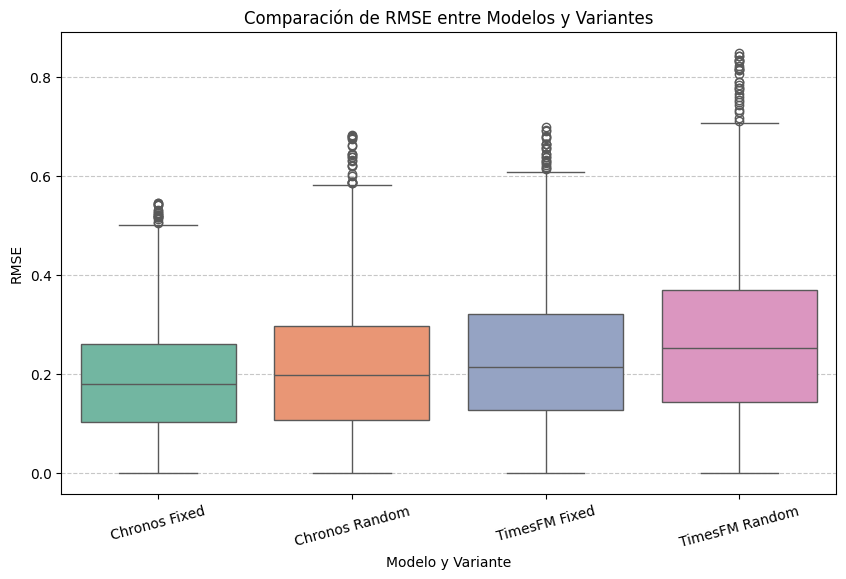

In [5]:
def remove_outliers(df):
    Q1 = df.quantile(0.25)  # Primer cuartil
    Q3 = df.quantile(0.75)  # Tercer cuartil
    IQR = Q3 - Q1           # Rango intercuartil
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df >= lower_bound) & (df <= upper_bound)]

# Aplicar la eliminación de outliers a cada columna

rmse_columns = ["rmse_chronos_fixed", "rmse_chronos_random", "rmse_timesfm_fixed", "rmse_timesfm_random"]
rmse_df = errors[rmse_columns]

# Renombrar columnas para mejor visualización en el gráfico
rmse_df = rmse_df.rename(columns={
    "rmse_chronos_fixed": "Chronos Fixed",
    "rmse_chronos_random": "Chronos Random",
    "rmse_timesfm_fixed": "TimesFM Fixed",
    "rmse_timesfm_random": "TimesFM Random"
})
rmse_df = rmse_df.apply(remove_outliers)

# Convertir el DataFrame a formato largo para Seaborn
rmse_long = rmse_df.melt(var_name="Modelo", value_name="RMSE").dropna()

# Configurar el gráfico
plt.figure(figsize=(10, 6))
sns.boxplot(x="Modelo", y="RMSE", data=rmse_long, palette="Set2")

# Añadir etiquetas y título
plt.xlabel("Modelo y Variante")
plt.ylabel("RMSE")
plt.title("Comparación de RMSE entre Modelos y Variantes")
plt.xticks(rotation=15)  # Rotar etiquetas si es necesario
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.show()

C:\Users\Asier\AppData\Local\Temp\ipykernel_9464\2753735392.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Modelo", y="MAPE", data=mape_long, palette="Set2")


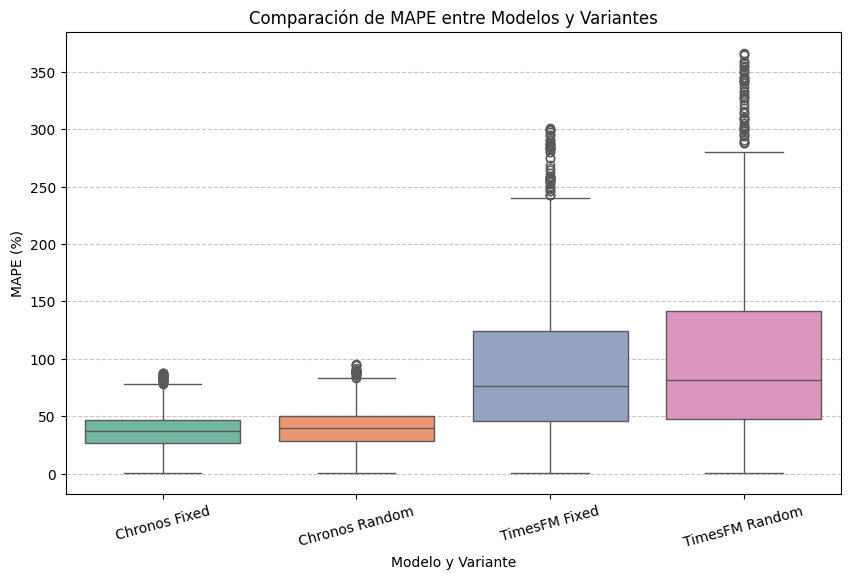

In [6]:
# Definir función para eliminar outliers
def remove_outliers(df):
    Q1 = df.quantile(0.25)  # Primer cuartil
    Q3 = df.quantile(0.75)  # Tercer cuartil
    IQR = Q3 - Q1           # Rango intercuartil
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df >= lower_bound) & (df <= upper_bound)]

# Seleccionar columnas de MAPE
mape_columns = ["mape_chronos_fixed", "mape_chronos_random", "mape_timesfm_fixed", "mape_timesfm_random"]
mape_df = errors[mape_columns]

# Renombrar columnas para mejor visualización en el gráfico
mape_df = mape_df.rename(columns={
    "mape_chronos_fixed": "Chronos Fixed",
    "mape_chronos_random": "Chronos Random",
    "mape_timesfm_fixed": "TimesFM Fixed",
    "mape_timesfm_random": "TimesFM Random"
})

# Aplicar eliminación de outliers
mape_df = mape_df.apply(remove_outliers)

# Convertir a formato largo para Seaborn
mape_long = mape_df.melt(var_name="Modelo", value_name="MAPE").dropna()

# Configurar el gráfico
plt.figure(figsize=(10, 6))
sns.boxplot(x="Modelo", y="MAPE", data=mape_long, palette="Set2")

# Etiquetas y título
plt.xlabel("Modelo y Variante")
plt.ylabel("MAPE (%)")
plt.title("Comparación de MAPE entre Modelos y Variantes")
plt.xticks(rotation=15)  # Rotar etiquetas si es necesario
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.show()

Prueba con un solo archivo

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


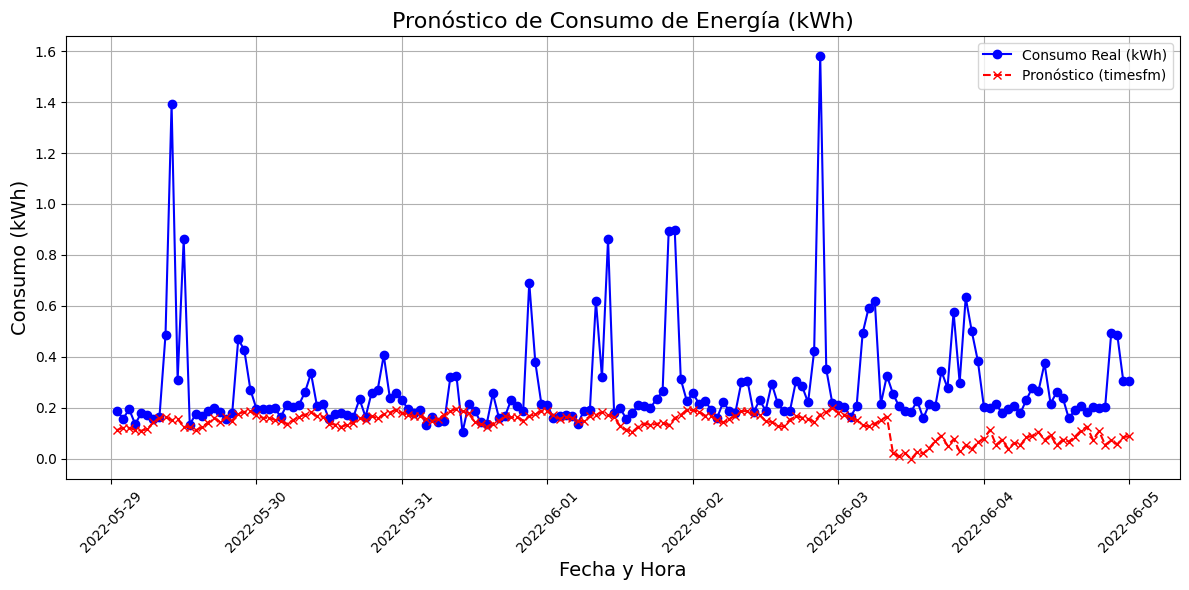

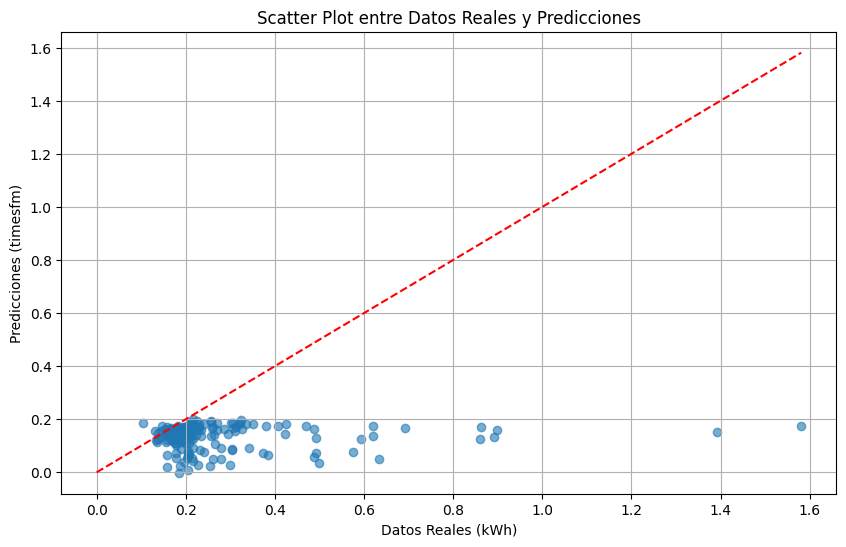

MAPE: nan%
RMSE: nan


,unique_id,ds,timesfm
0,series_1,2022-05-29 01:00:00,0.112690
1,series_1,2022-05-29 02:00:00,0.120995
2,series_1,2022-05-29 03:00:00,0.121059
3,series_1,2022-05-29 04:00:00,0.112929
4,series_1,2022-05-29 05:00:00,0.109935
...,...,...,...
163,series_1,2022-06-04 20:00:00,0.054543
164,series_1,2022-06-04 21:00:00,0.071708
165,series_1,2022-06-04 22:00:00,0.055926
166,series_1,2022-06-04 23:00:00,0.085348


In [14]:
file = "../../goi4_pst/imp_csv/000bf84faacf921b55bd4ec4aecda599754e9017e150091d330afc038f0fab11.csv"

df = pd.read_csv(file, index_col=None)
if all(col in df.columns for col in ['timestamp', 'kWh', 'imputed']):
                # Convertir la columna 'timestamp' a datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])

                # Seleccionar solo las columnas necesarias
                df = df[['timestamp', 'kWh', 'imputed']]



dataframe_original = df.copy() #todo
dataframe_remove = dataframe_original.iloc[:-HORIZON_LEN].copy() #quitando datos a predecir
dataframe_rdata = dataframe_original.iloc[-HORIZON_LEN:].copy() #datos a predecir




input_df = dataframe_remove  # Cambia el índice según la serie que deseas usar

# Reset the index to make 'timestamp' a column again
input_df.reset_index(inplace=True)

# Renombrar columnas para cumplir con los requisitos de timesfm
input_df.rename(columns={"timestamp": "ds", "kWh": "kWh"}, inplace=True)

# Agregar una columna 'unique_id'
input_df['unique_id'] = 'series_1'  # Asigna un ID único para esta serie

# Pronosticar
forecast_df = tfm.forecast_on_df(
    inputs=input_df,
    freq="h",  # hourly
    value_name="kWh",
    num_jobs=-1,
)


prediccion = forecast_df.copy()
prediccion = prediccion.iloc[:,:3]


# Primera gráfica
plt.figure(figsize=(12, 6))  # Crear una nueva figura
plt.plot(dataframe_rdata['timestamp'], dataframe_rdata['kWh'], marker='o', linestyle='-', color='b', label='Consumo Real (kWh)')
plt.plot(prediccion['ds'], prediccion['timesfm'], marker='x', linestyle='--', color='r', label='Pronóstico (timesfm)')
plt.title('Pronóstico de Consumo de Energía (kWh)', fontsize=16)
plt.xlabel('Fecha y Hora', fontsize=14)
plt.ylabel('Consumo (kWh)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()  # Mostrar la primera gráfica



# Supongamos que dataframe_rdata tiene los valores reales y prediccion tiene los valores predichos
y_true = dataframe_rdata['kWh'] # Valores reales
y_pred = prediccion['timesfm']   # Valores predichos

# Calcular MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calcular RMSE
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

# Asegúrate de que ambos DataFrames tengan el mismo número de filas
if len(dataframe_rdata) != len(prediccion):
    print("Los DataFrames no tienen la misma longitud.")
else:
    # Crear un scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(dataframe_rdata['kWh'], prediccion['timesfm'], alpha=0.6)

    # Añadir la recta y=x
    max_value = max(dataframe_rdata['kWh'].max(), prediccion['timesfm'].max())
    plt.plot([0, max_value], [0, max_value], color='red', linestyle='--', label='y=x')

    # Personalizar la gráfica
    plt.title('Scatter Plot entre Datos Reales y Predicciones')
    plt.xlabel('Datos Reales (kWh)')
    plt.ylabel('Predicciones (timesfm)')
    plt.grid(True)

    # Mostrar la gráfica
    plt.show()

# Mostrar resultados
print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.4f}')


prediccion

In [18]:
y_true[y_true != 0]

8713    0.189
8714    0.157
8715    0.194
8716    0.136
8717    0.179
        ...  
8876    0.203
8877    0.492
8878    0.487
8879    0.304
8880    0.304
Name: kWh, Length: 168, dtype: float64